In [1]:
import datetime

import numpy as np
import pandas as pd
import plotnine as gg

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Things to get
## Plots
- Match summary, plot all of the frames for each end for the whole match
- Stone heatmap
    - Stone heatmap per tournament or per year
- Player accuracy vs number of shots

## Stats
- Player accuracy
- Player accuracy by year, tournament
- Shot type frequency
- Accuracy by shot type
- Shot type frequency by type of shot

## Questions
- Who are the best/most accurate players for certain throws(over 50 or 100) total throws
- Table of players and their accuracy for each type of throw
- For a single player
    - Accuracy for each type of throw
    - Accuracy for each tournament or match they attended
    - Count number of ends for which they player which position


## Create Database Connection

In [3]:
# db = CurlingDB()
db = CurlingDB(db_name='stone_position.db')

## Curling Dimensions

In [4]:
# All values in m
circles = [0.152, 0.610, 1.219, 1.829]
pixel_to_m = 0.007370759
ice_width = [-4.75/2, 4.75/2]
ice_length = [-2, 6.401]
stone_radius = 14.5

# Circle values
inc = np.pi / 16
circle_range_x = np.cos(np.arange(0, 2 * np.pi + inc, inc))
circle_range_y = np.sin(np.arange(0, 2 * np.pi + inc, inc))

# Some Plots

## Stone Position Testing

### Query

In [5]:
stone_position_cmd = """
SELECT x, y, colour, frame_num, m.type
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e
  ON p.end_id = e.end_id
JOIN Match m
  ON e.match_id = m.match_id
"""
db.execute_query(stone_position_cmd)
all_stone_positions = pd.DataFrame(db.cursor.fetchall(), columns=['x', 'y', 'colour', 'frame_num', 'match_type'])
print(all_stone_positions.shape)
all_stone_positions.head()

(12022, 5)


x         y  colour  frame_num     match_type
0  0.003685  3.324212     red          0  Mixed_Doubles
1  0.003685 -0.464358  yellow          0  Mixed_Doubles
2  0.022112 -0.243235     red          1  Mixed_Doubles
3  0.007371  3.324212     red          1  Mixed_Doubles
4 -0.007371 -0.589661  yellow          1  Mixed_Doubles

### Filter out the top n most common

In [6]:
top_offenders = all_stone_positions[['x', 'y']].value_counts()[:6]
top_x = top_offenders.index.get_level_values(0)
top_y = top_offenders.index.get_level_values(1)
limited_stones = all_stone_positions.loc[(all_stone_positions.apply(lambda c: c['x'] not in top_x, axis=1) & (all_stone_positions.apply(lambda c: c['y'] not in top_y, axis=1)))]

### Create heatmap

#### Women's Heatmap

In [7]:
def stone_heatmap(df, match_type: str=None, size=5):

     if match_type is not None:
          plot_df = df.query('match_type == @match_type')
     else:
          plot_df = df
     
     return (gg.ggplot(plot_df, gg.aes(x='x', y='y'))
          + gg.geom_bin_2d()
          + gg.facet_grid('. ~ frame_num')
          + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour='white', size=1.25)
          + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour='white', size=1.25)
          + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour='white', size=1.25)
          + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour='white', size=1.25)

          + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
          + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
          # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#E41C16'], values=[0, 0.3, 1], guide=False)
          + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ffD000'], values=[0, 0.3, 1], guide=False)

          + gg.theme(text=gg.element_text(colour='#ffffff'))
          + gg.theme(axis_text=blank)
          + gg.theme(axis_title=blank)
          + gg.theme(figure_size=(size * (plot_df.frame_num.max() + 1 if match_type == 'Mixed_Doubles' else plot_df.frame_num.max()), size * ((800 + 300)/(600))))

          + pe.background_colour(colour='black', plot_colour='black')
          + pe.remove_ticks(minor=True)
          )


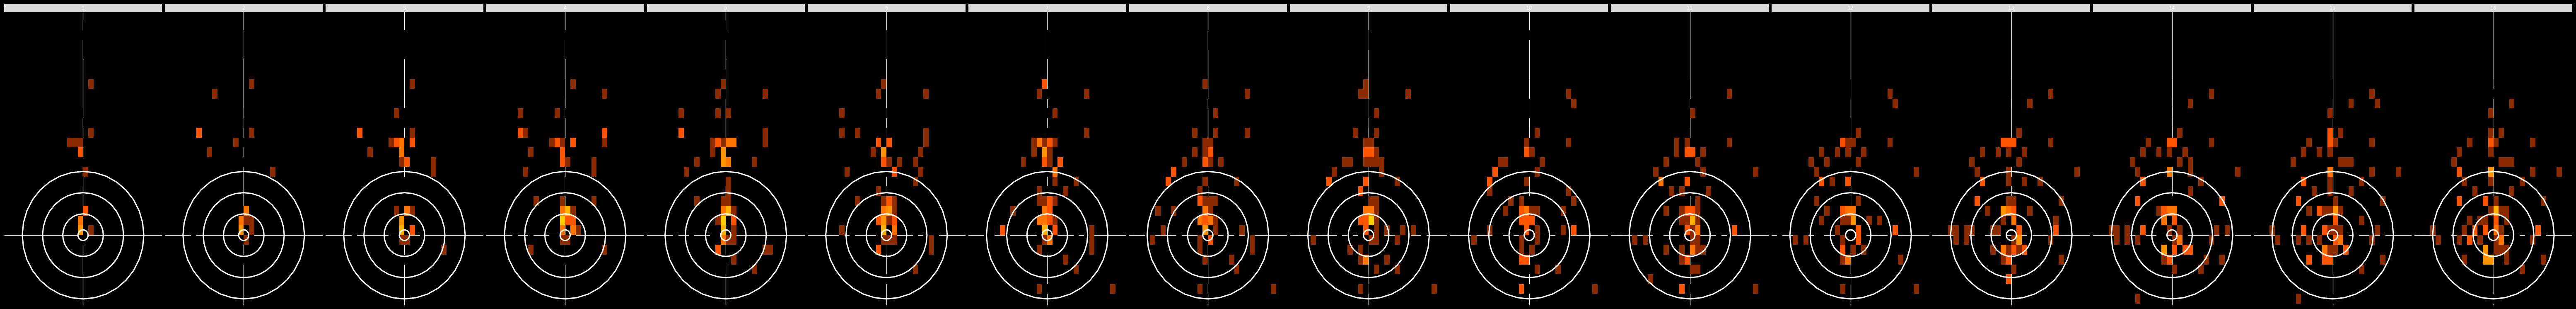

<ggplot: (696046324)>

In [8]:
stone_heatmap(limited_stones, match_type='Womens_Teams')

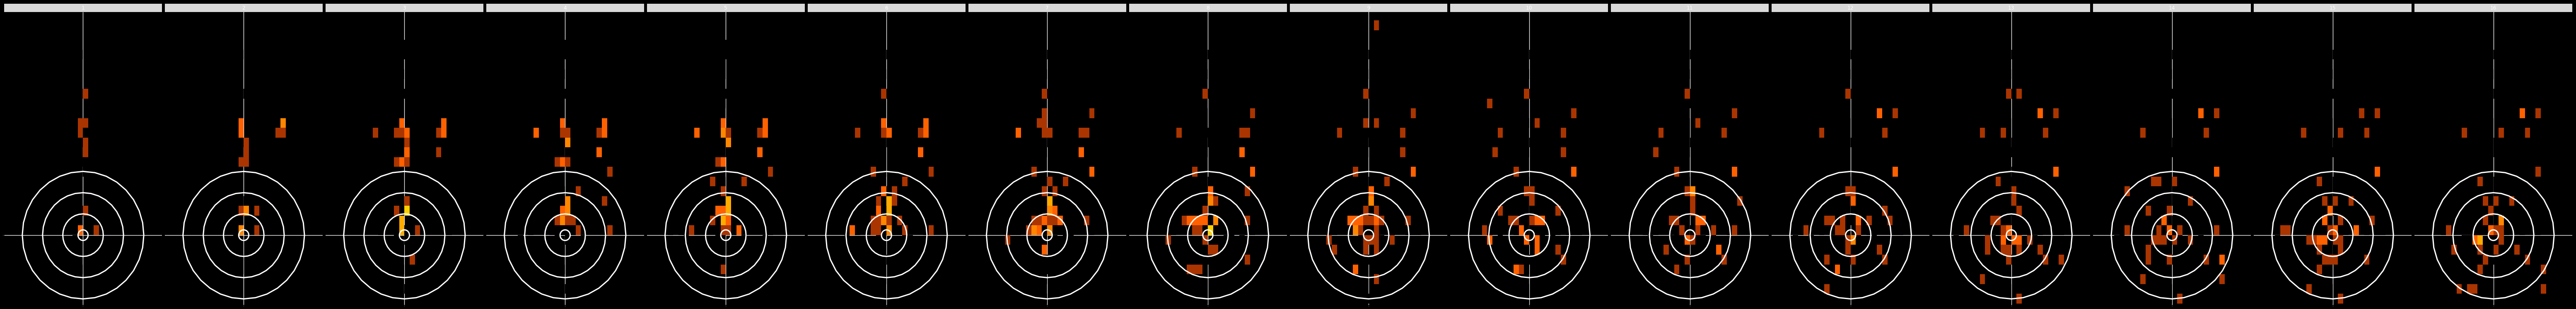

<ggplot: (710345972)>

In [9]:
stone_heatmap(limited_stones, match_type='Mens_Teams')

In [10]:
stone_heatmap(limited_stones, match_type='Mixed_Teams')

PlotnineError: 'Faceting variables must have at least one value'

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 6 rows containing missing values.


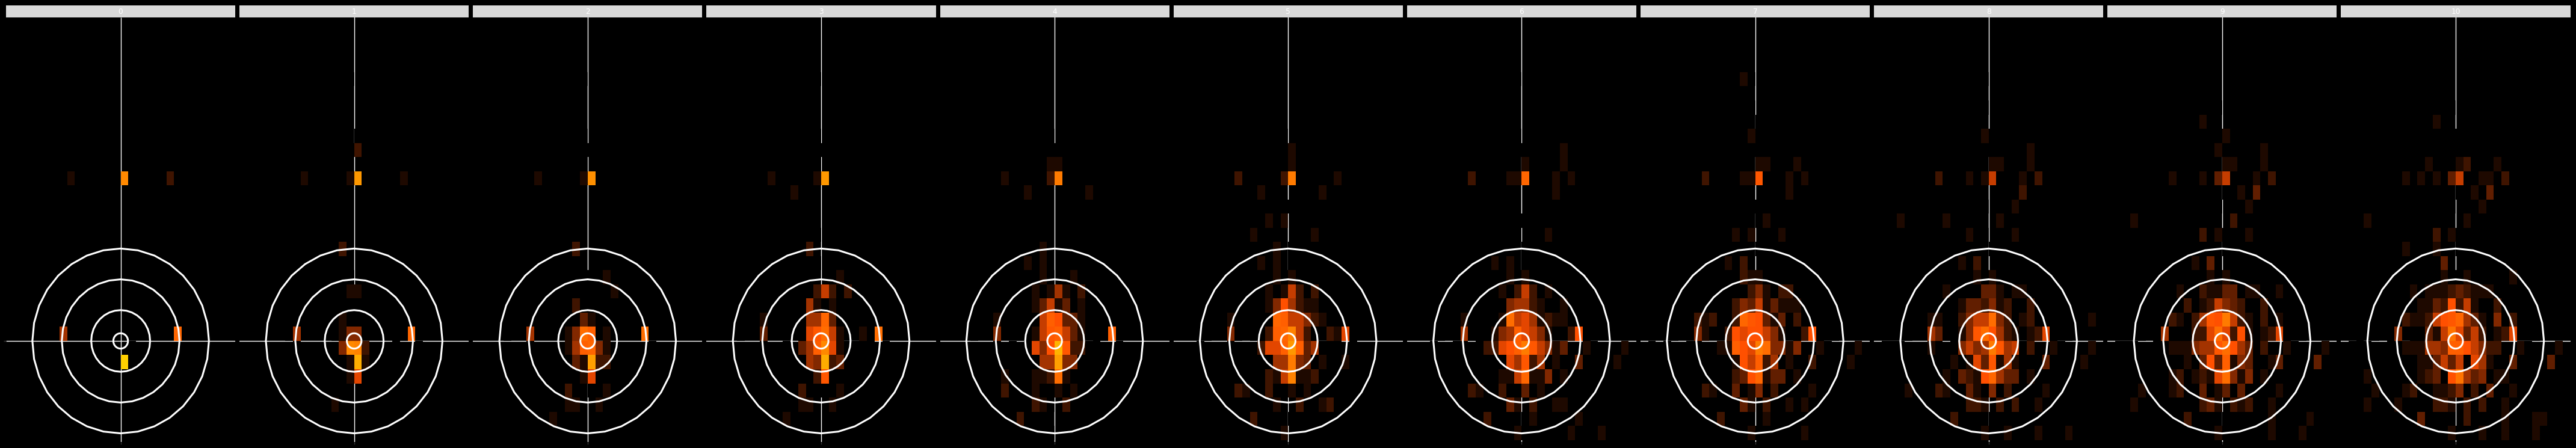

<ggplot: (712377841)>

In [11]:
stone_heatmap(limited_stones, match_type='Mixed_Doubles')

## Match Summary
- TODO: Could introduce another query to get match specific, end specific, and frame/throw specific information
    - Include accuracy per team per end
    - Include type of throw per frame
    - Include player
    - Include current score


### Query
- 2093, 2097, 2099, 2100, 2106

In [13]:
match_summary_cmd = """
SELECT m.team_1, m.team_2, e.num, e.hammer_colour, e.direction, p.frame_num, s.x, s.y, s.colour, s.size
FROM Stone s
RIGHT JOIN Position p
ON s.position_id = p.position_id
JOIN End e
ON p.end_id = e.end_id
JOIN Match m
ON e.match_id = m.match_id
WHERE m.match_id = ?
"""
db.execute_query(match_summary_cmd, (11,))
match_summary = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'x', 'y', 'colour', 'size'])
print(match_summary.shape)
match_summary.head()

(406, 10)


team_1 team_2  end_num hammer_colour play_direction  frame_num         x  \
0    OAR    GBR        1           red           down          1  0.077393   
1    OAR    GBR        1           red           down          2  0.866064   
2    OAR    GBR        1           red           down          2  0.070022   
3    OAR    GBR        1           red           down          3  0.862379   
4    OAR    GBR        1           red           down          3  0.066337   

          y  colour  size  
0  0.567548  yellow  40.0  
1  3.736975     red  40.0  
2  0.574919  yellow  58.0  
3  3.744346     red  58.0  
4  0.574919  yellow  58.0

### Match Heatmap

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


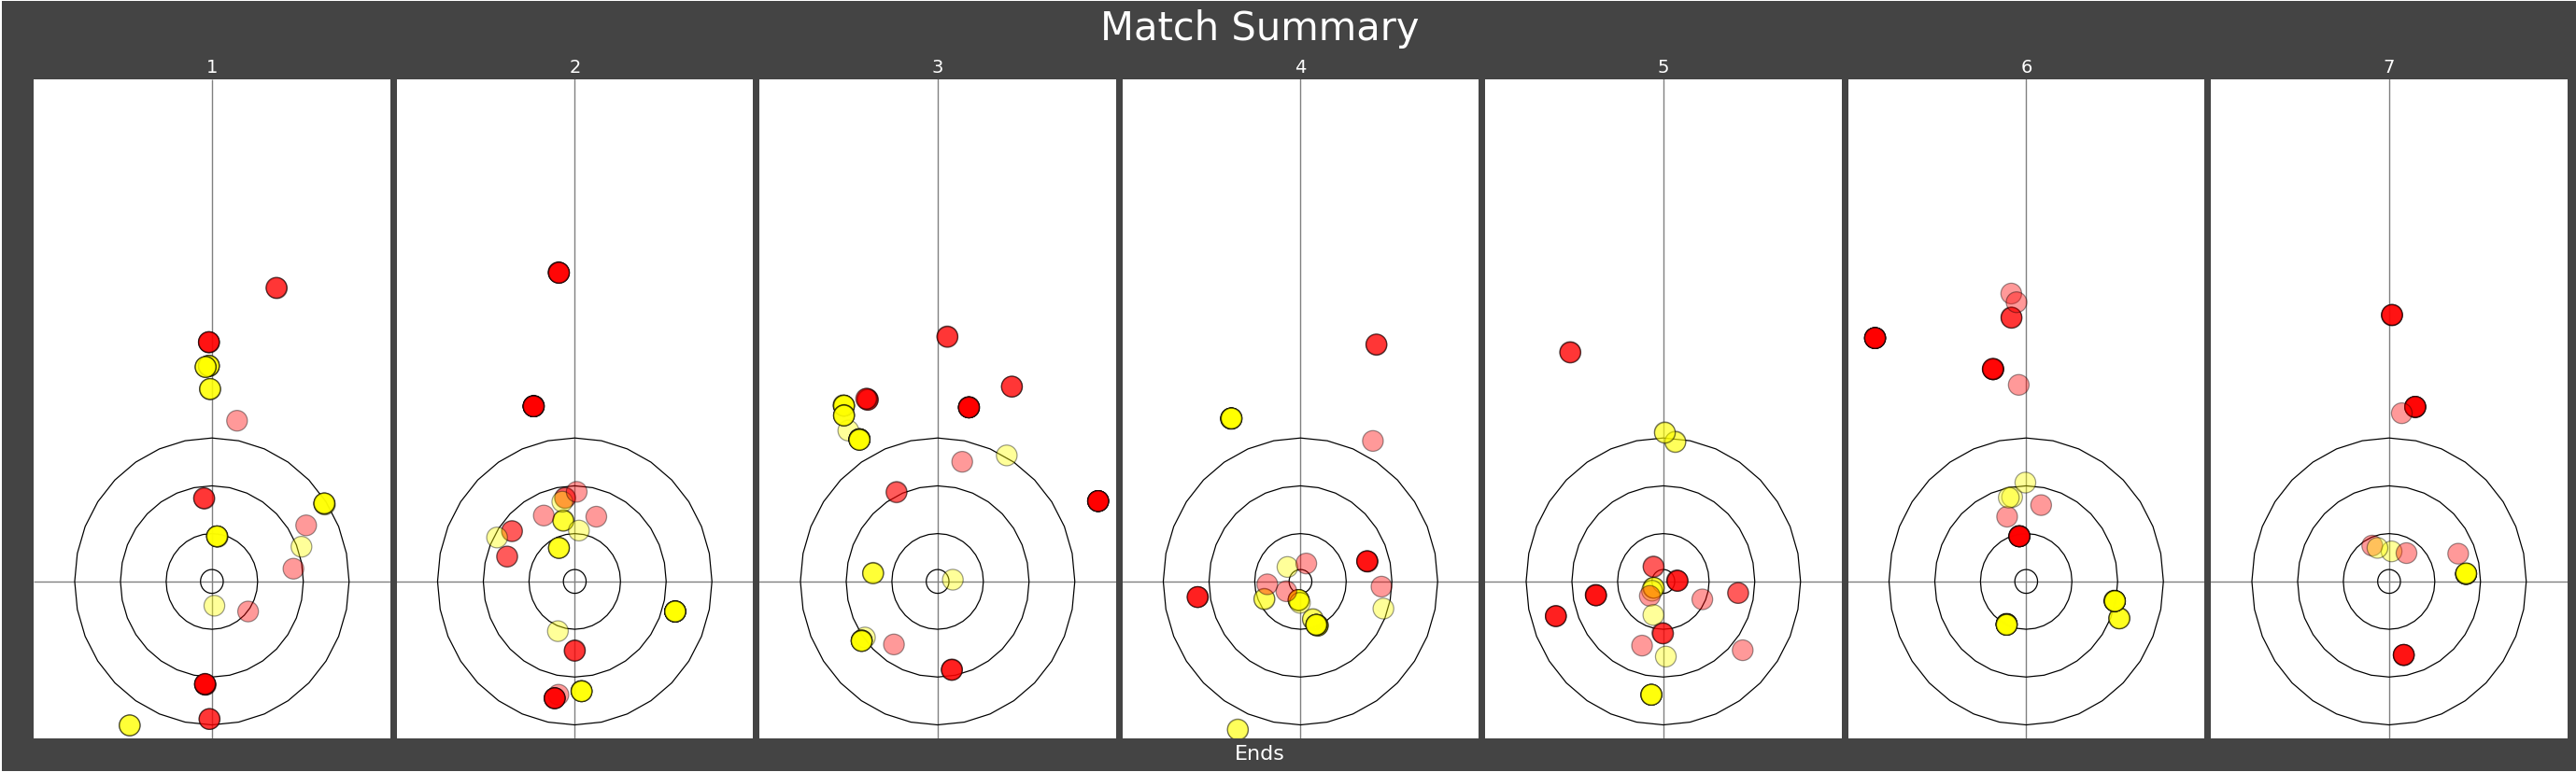

<ggplot: (723299545)>

In [30]:
size = 5
(gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(alpha = 0.4, size=8.5)

    + gg.facet_grid('. ~ end_num')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)

    + gg.theme(figure_size=(size * (match_summary.end_num.max()), size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank)
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title='Match Summary', x='Ends', y=' ', title_size=30, x_size=16, y_size=16)
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


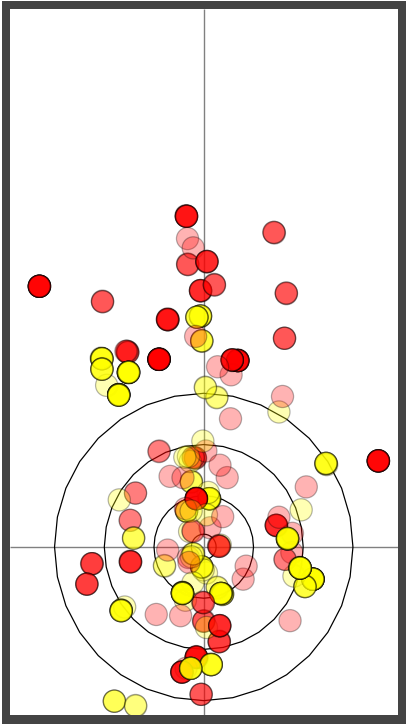

<ggplot: (723614344)>

In [34]:
(gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(alpha = 0.3, size=8.5)


    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)

    + gg.theme(figure_size=(size, size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank, axis_title_x=blank, axis_title_y=blank, title=gg.element_text('Match Stone Locations'))
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    )

### Plot

In [ ]:
# Change the colour of all the stones to something different, the smallest stone for each frame and end should be a different colour

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


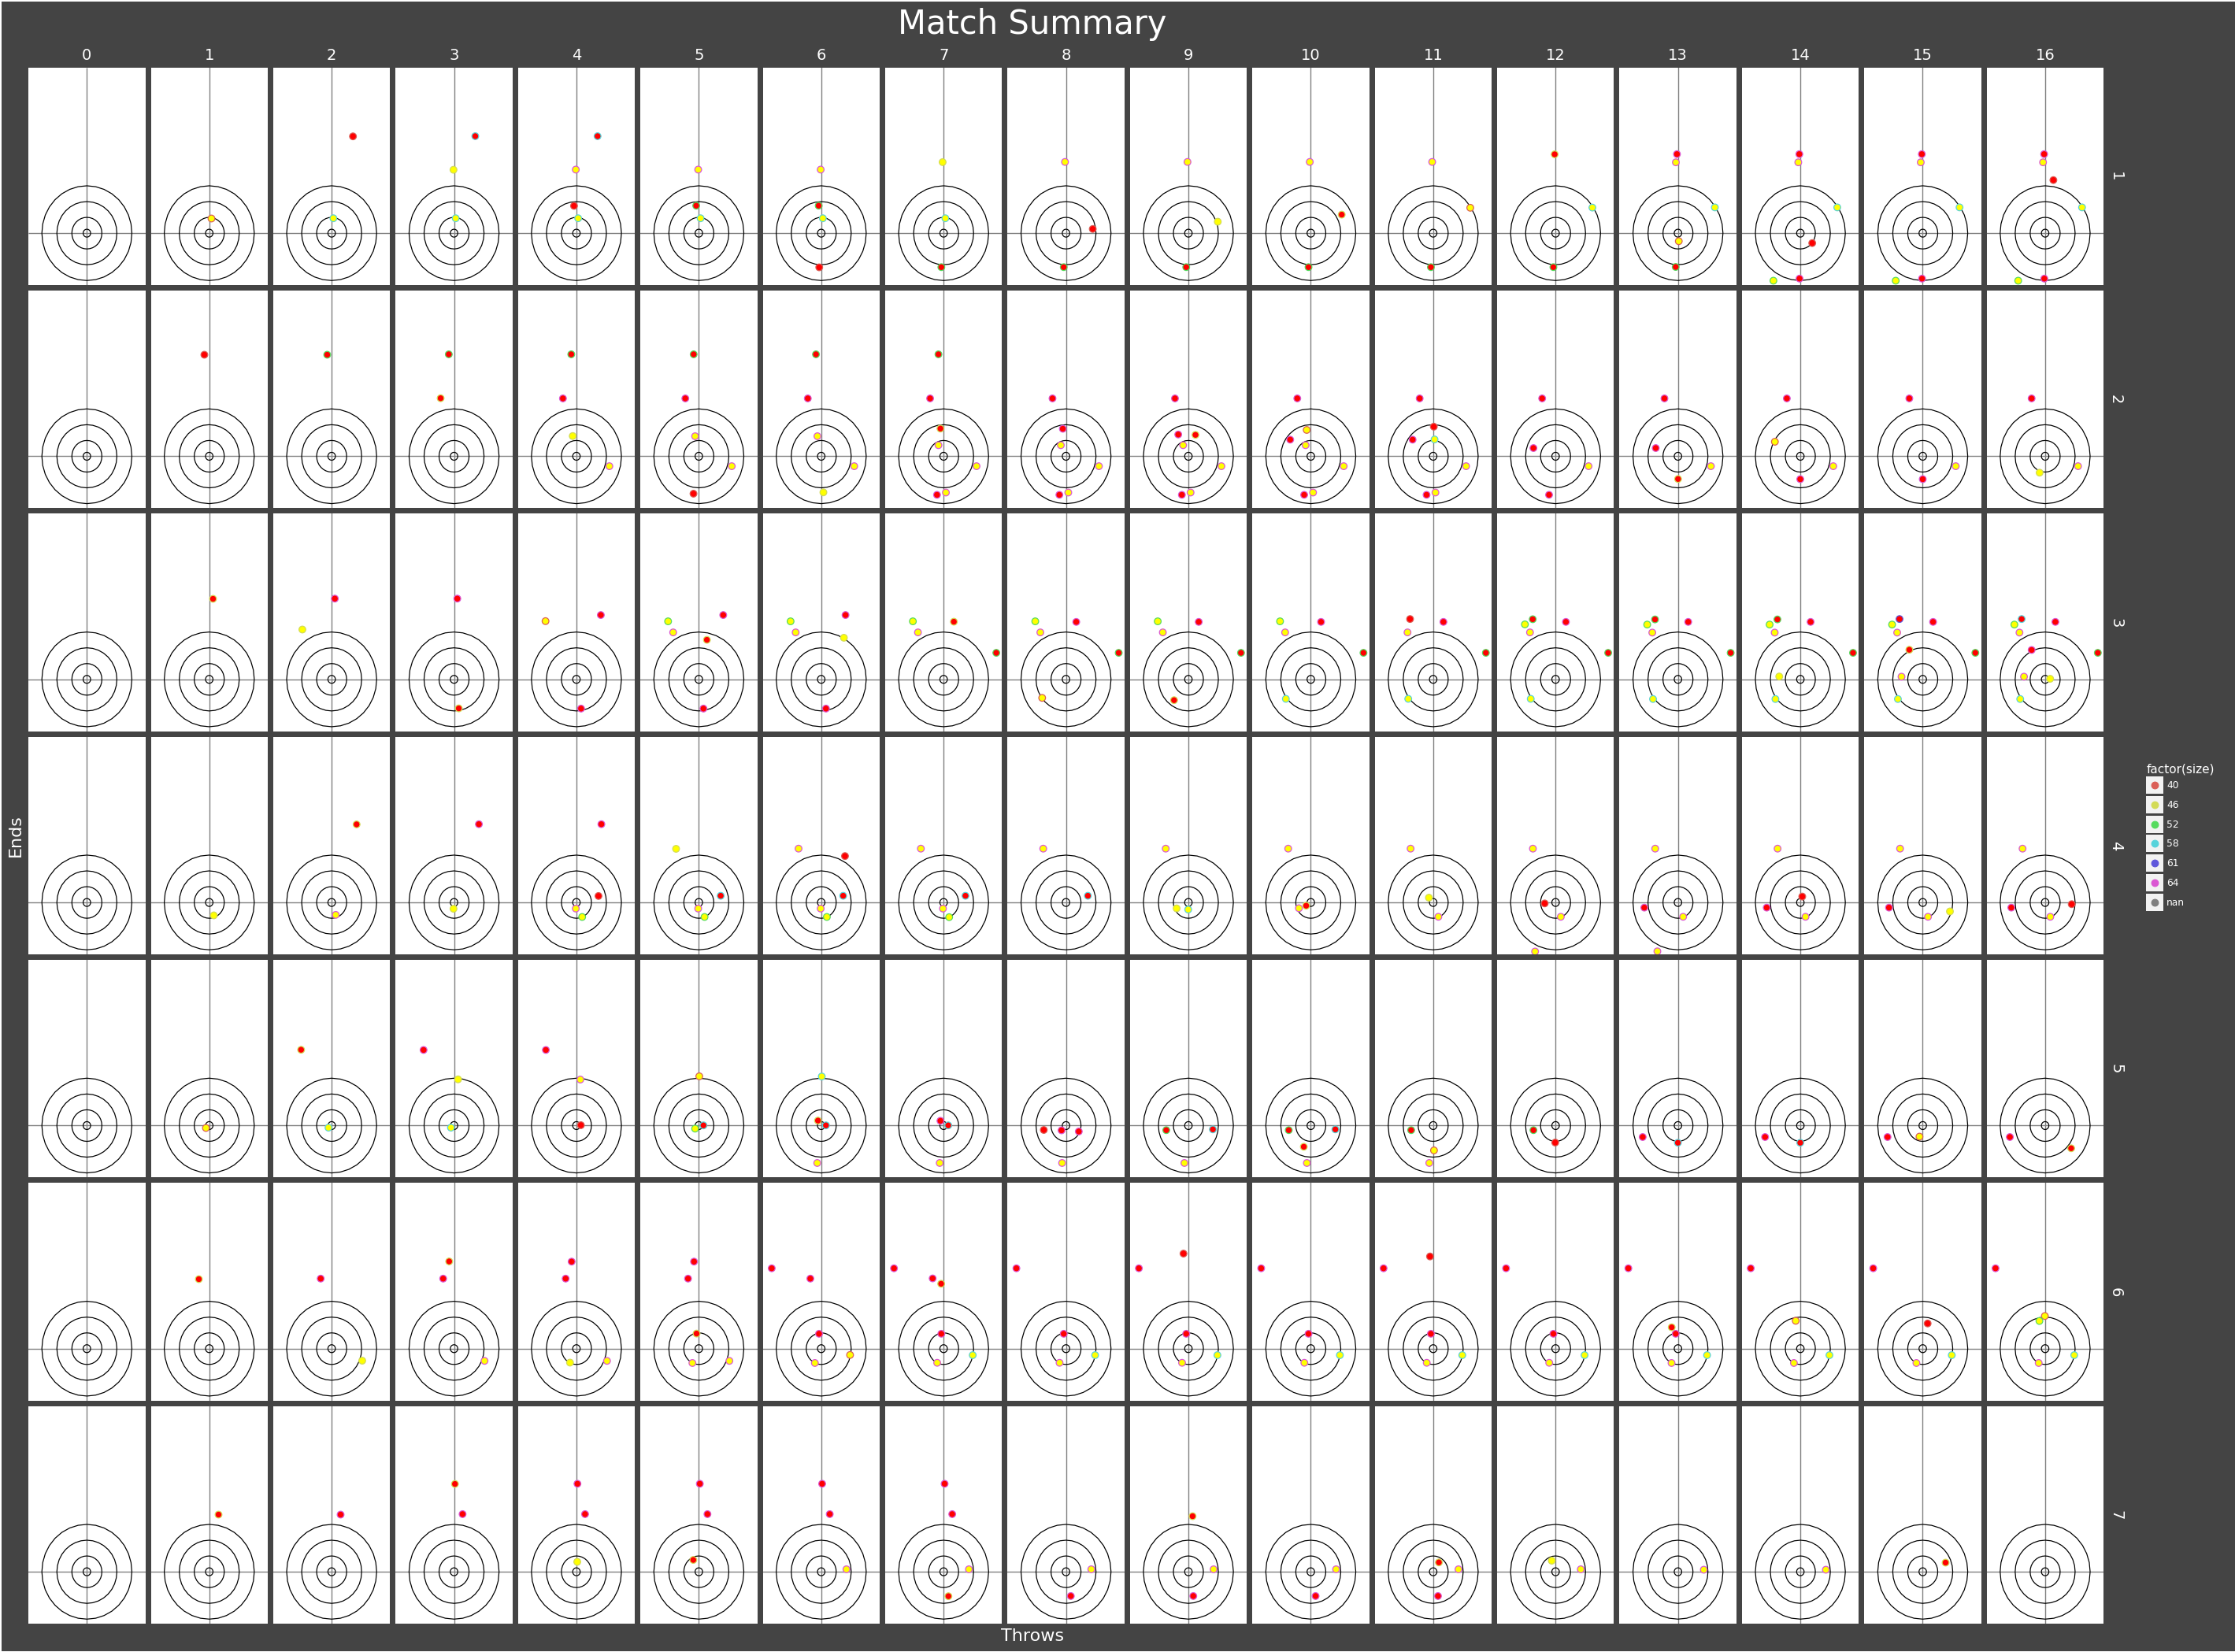

<ggplot: (714721265)>

In [19]:
size = 2
(gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='colour', colour='factor(size)'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(size=3)

    + gg.facet_grid('end_num ~ frame_num', space='free')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)
    + gg.theme(figure_size=(size * (match_summary['frame_num'].max() + 1), size * (match_summary['end_num'].max()) * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank)
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank, legend_background=gg.element_rect('#444444'))

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title='Match Summary', x='Throws', y='Ends', title_size=30, x_size=16, y_size=16)
    )

## Linking Throws and Positions for Rating per Throw Type

### Query

In [14]:
# Get each throw along with the count of stones
linking_cmd = """
SELECT frames.position_id, frames.type, frames.num, frames.frame_num, frames.coun, throws.colour, throws.name, throws.team, throws.sex, throws.type, throws.rating
FROM
(SELECT p.frame_num, 
        e1.num,
        p.position_id,
        e1.end_id,
        m1.type,
        COUNT(*) as coun
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e1
  ON p.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
GROUP BY 3
) frames
LEFT JOIN
(SELECT t.throw_num, 
        t.colour, 
        p.name, 
        p.team, 
        p.sex,
        t.type, 
        t.rating, 
        e1.num,
        e1.end_id
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
JOIN End e1
  ON t.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
) throws
  ON frames.frame_num = throws.throw_num AND frames.end_id = throws.end_id

"""
db.execute_query(linking_cmd)
# linking = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'rating', 'x', 'y', 'colour'])
linking = pd.DataFrame(db.cursor.fetchall(), columns=['position_id', 'match_type', 'end_num', 'throw_num', 'stone_count', 'colour', 'name', 'team', 'sex', 'type', 'rating'])
print(linking.shape)
linking.head()

(255246, 11)


position_id    match_type  end_num  throw_num  stone_count  colour  \
0            2  Womens_Teams        1          1            1  yellow   
1            3  Womens_Teams        1          2            2     red   
2            4  Womens_Teams        1          3            3  yellow   
3            5  Womens_Teams        1          4            3     red   
4            6  Womens_Teams        1          5            5  yellow   

                 name team sex      type  rating  
0  FREDERICKS ARMSTR.  AUS   f      Draw     0.0  
1          THOMPSON H  NZL   f     Front     2.0  
2  FREDERICKS ARMSTR.  AUS   f      Draw     3.0  
3          THOMPSON H  NZL   f      Draw     4.0  
4            POWELL A  AUS   f  Take-out     2.0

### Exploratory Plots

#### Throw Number

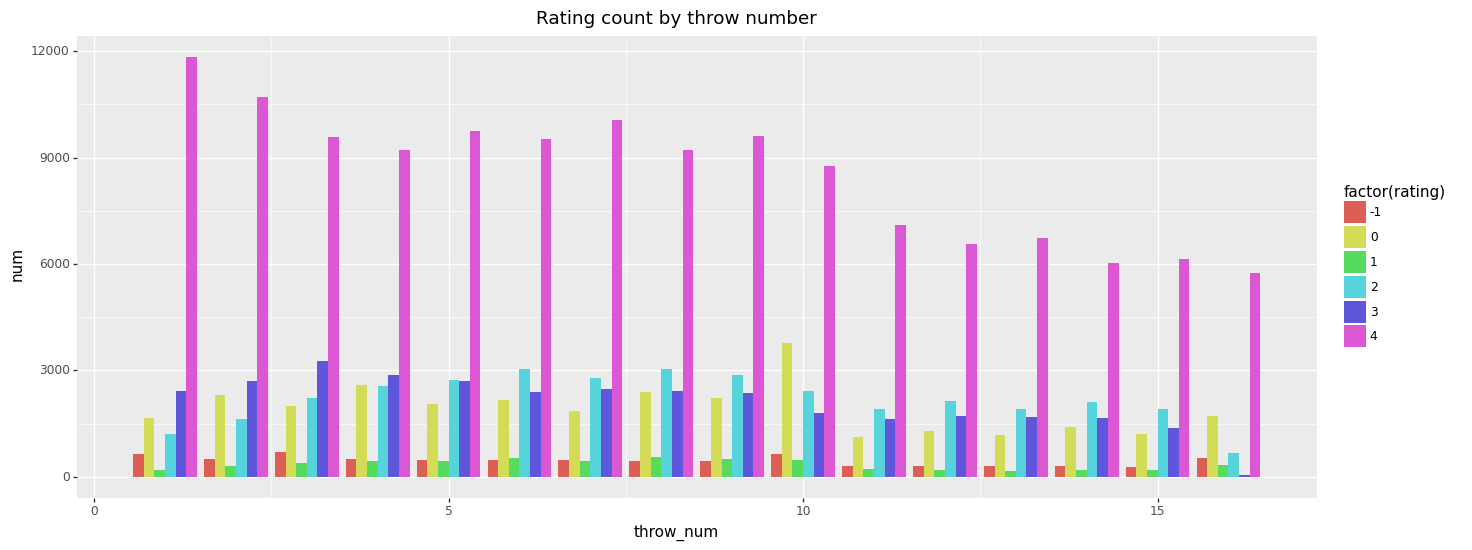

<ggplot: (693000409)>

In [15]:
(gg.ggplot(pd.DataFrame(linking[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='throw_num', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by throw number'))

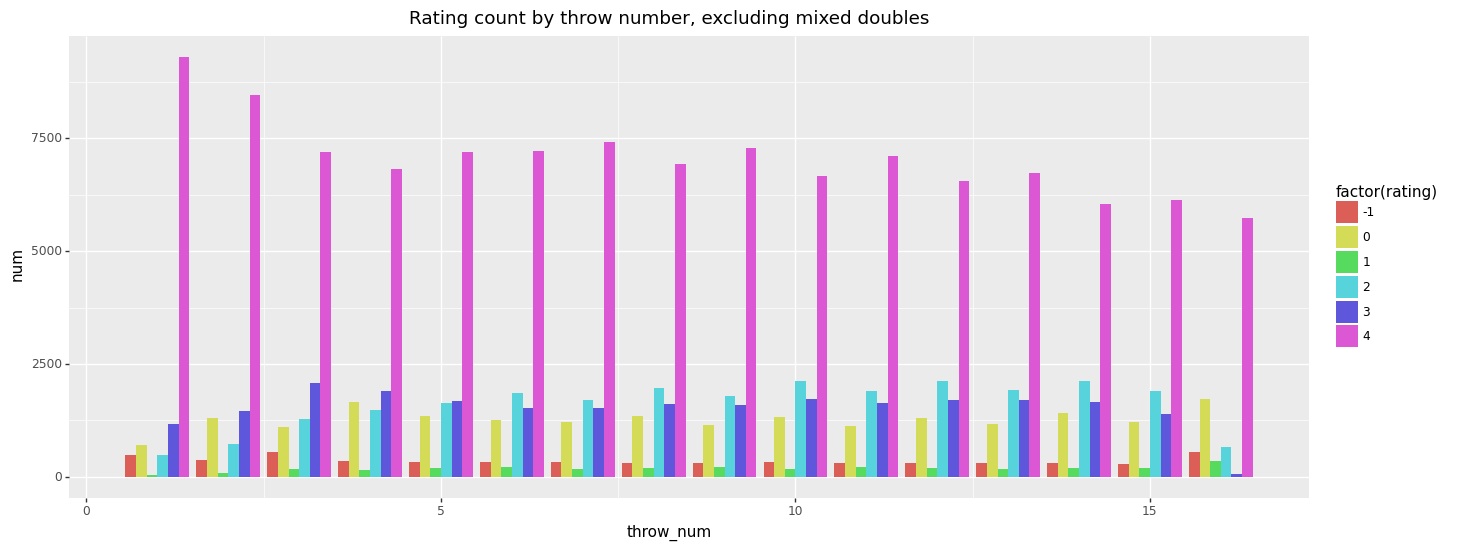

<ggplot: (694501476)>

In [16]:
(gg.ggplot(pd.DataFrame(linking.query('match_type != "Mixed_Doubles"')[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='throw_num', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by throw number, excluding mixed doubles'))

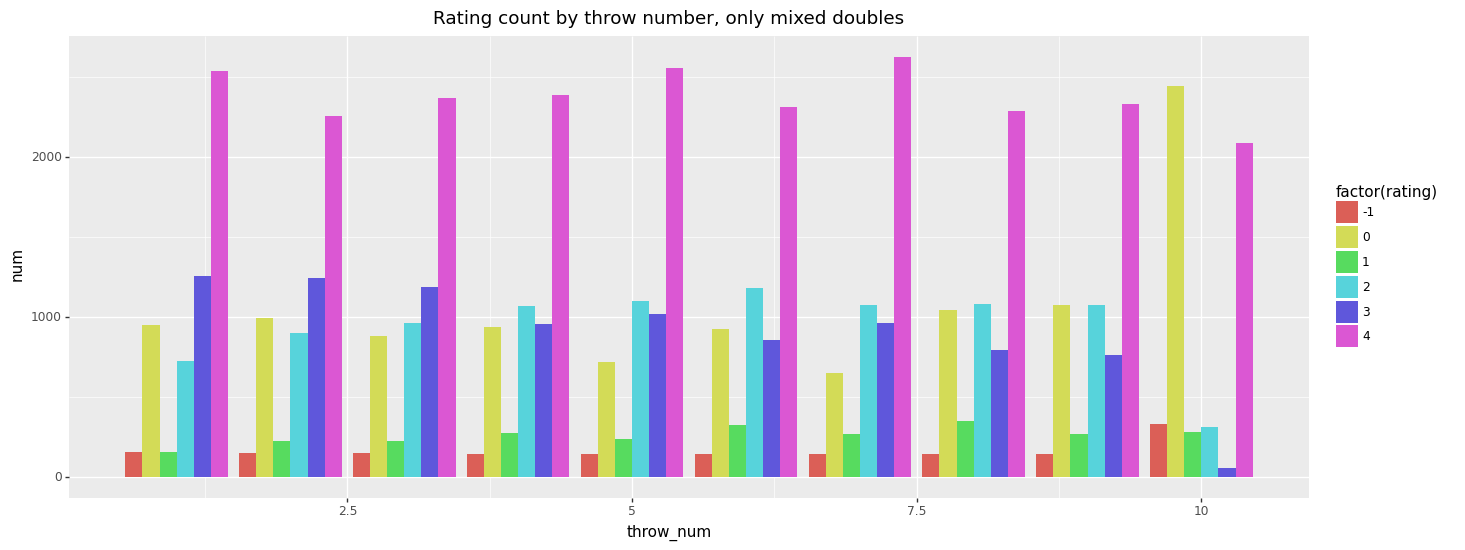

<ggplot: (694513978)>

In [17]:
(gg.ggplot(pd.DataFrame(linking.query('match_type == "Mixed_Doubles"')[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='throw_num', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by throw number, only mixed doubles'))

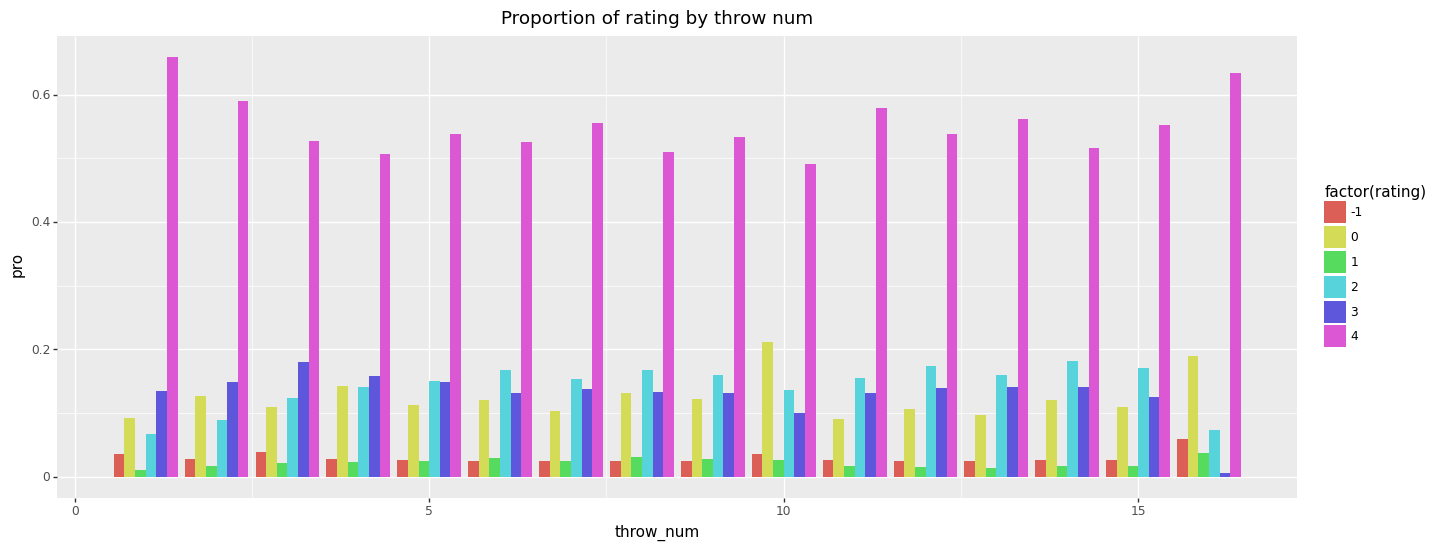

<ggplot: (739813280)>

In [18]:
df = pd.DataFrame(linking[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'})
df['pro'] = df.apply(lambda x: x['num'] / df.loc[df['throw_num'] == x['throw_num'], 'num'].sum(), axis=1)
(gg.ggplot(df, gg.aes(x='throw_num', y='pro', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Proportion of rating by throw num'))

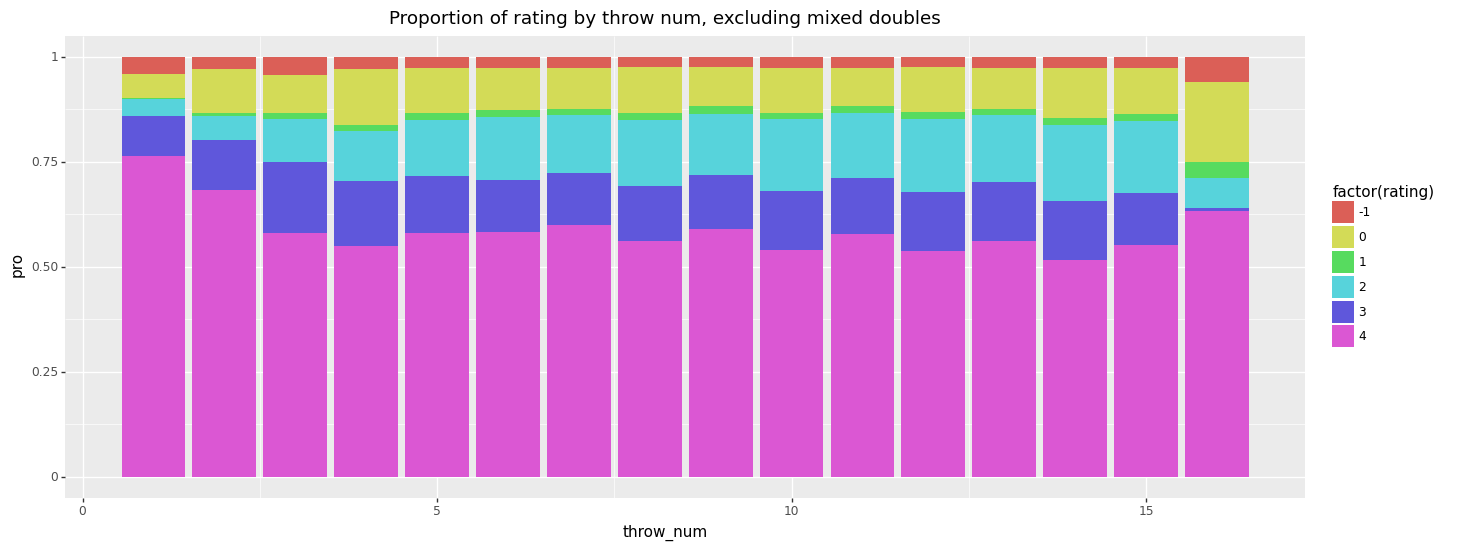

<ggplot: (696459539)>

In [19]:
df = pd.DataFrame(linking.query('match_type != "Mixed_Doubles"')[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'})
df['pro'] = df.apply(lambda x: x['num'] / df.loc[df['throw_num'] == x['throw_num'], 'num'].sum(), axis=1)
(gg.ggplot(df, gg.aes(x='throw_num', y='pro', fill='factor(rating)')) 
    + gg.geom_col() 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Proportion of rating by throw num, excluding mixed doubles'))

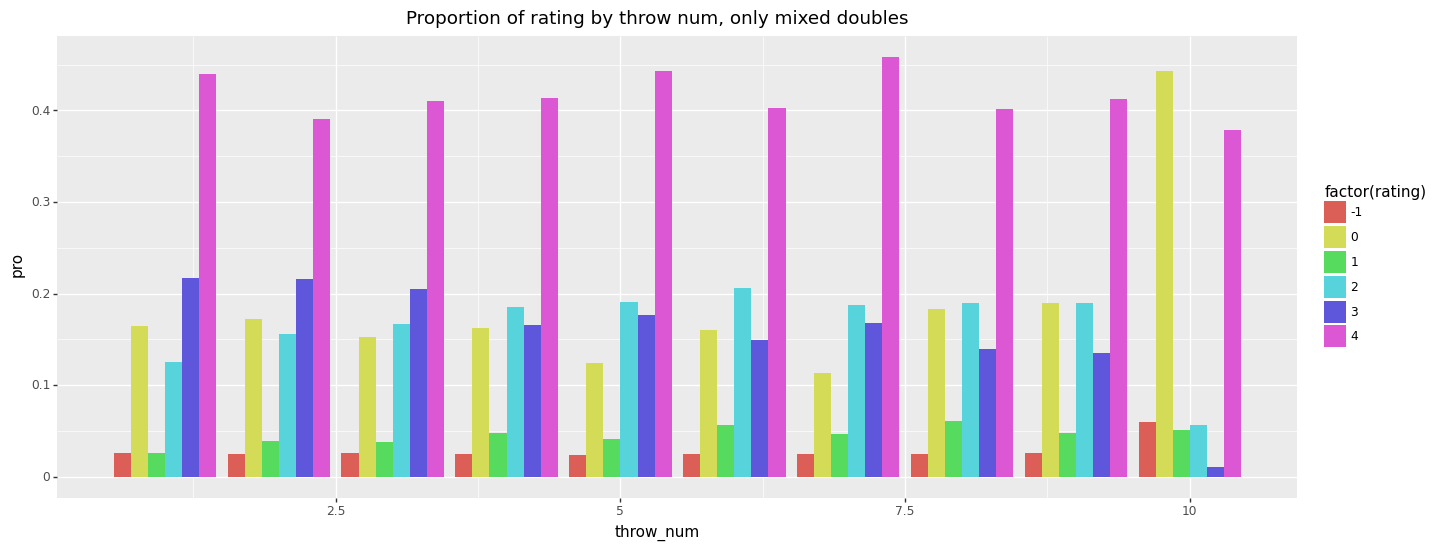

<ggplot: (694411418)>

In [20]:
df = pd.DataFrame(linking.query('match_type == "Mixed_Doubles"')[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'})
df['pro'] = df.apply(lambda x: x['num'] / df.loc[df['throw_num'] == x['throw_num'], 'num'].sum(), axis=1)
(gg.ggplot(df, gg.aes(x='throw_num', y='pro', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Proportion of rating by throw num, only mixed doubles'))

#### Stone Count

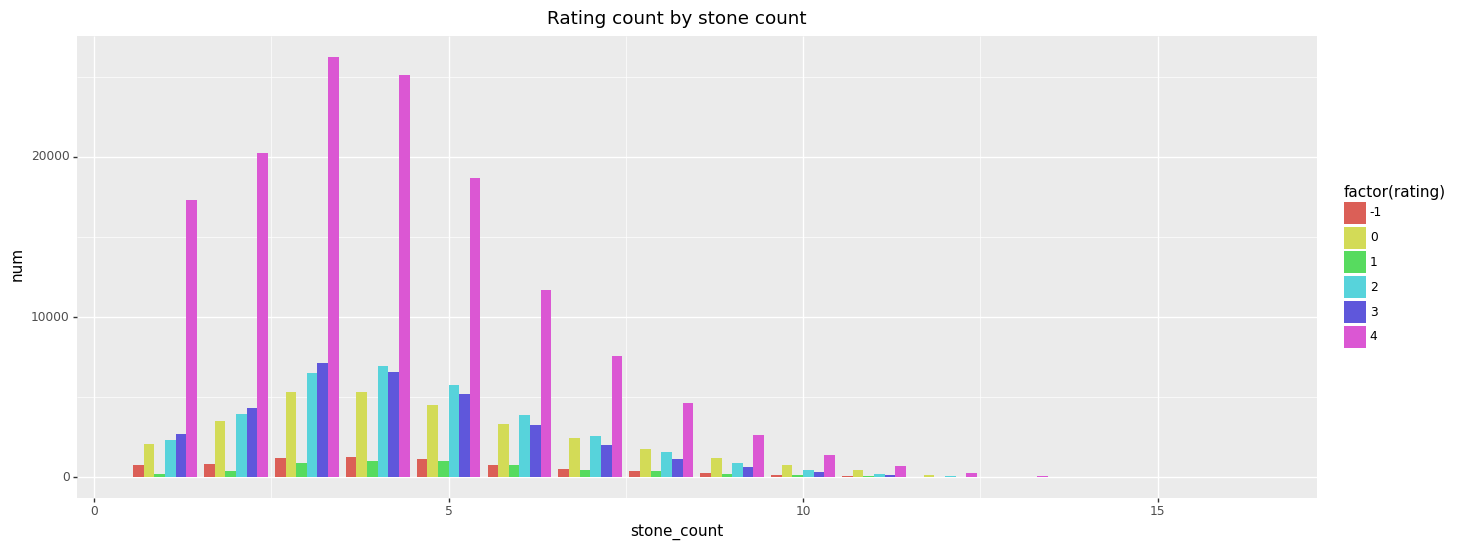

<ggplot: (697351458)>

In [21]:
(gg.ggplot(pd.DataFrame(linking[['stone_count', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='stone_count', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by stone count'))

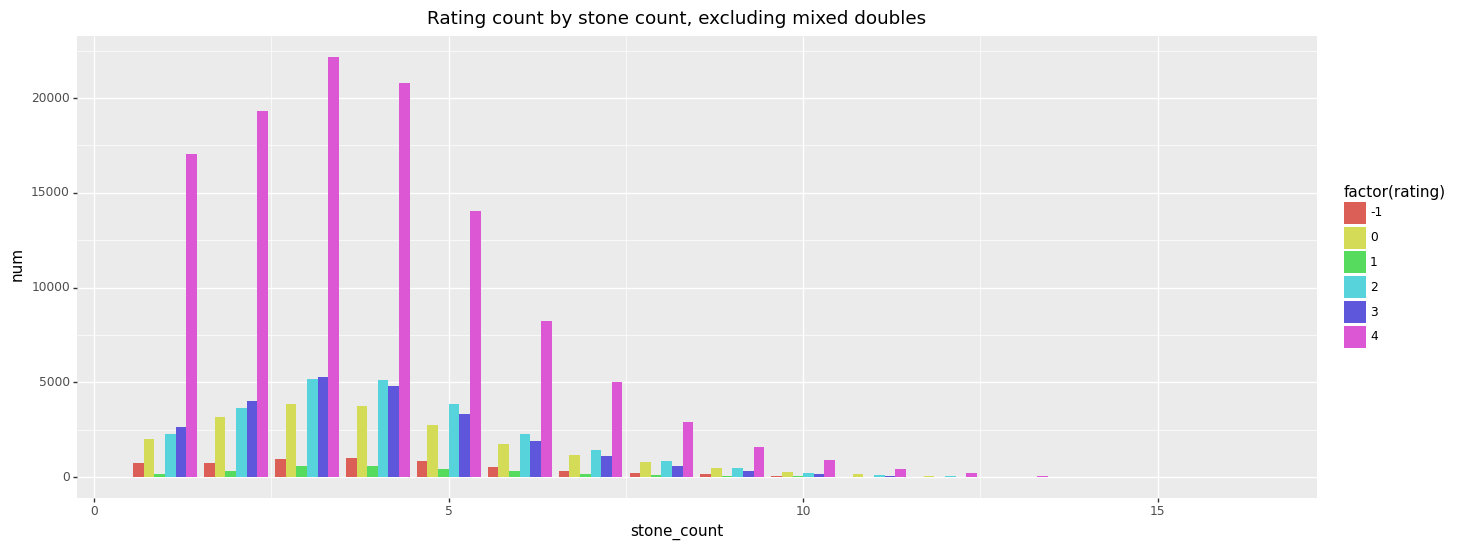

<ggplot: (694411466)>

In [22]:
(gg.ggplot(pd.DataFrame(linking.query('match_type != "Mixed_Doubles"')[['stone_count', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='stone_count', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by stone count, excluding mixed doubles'))

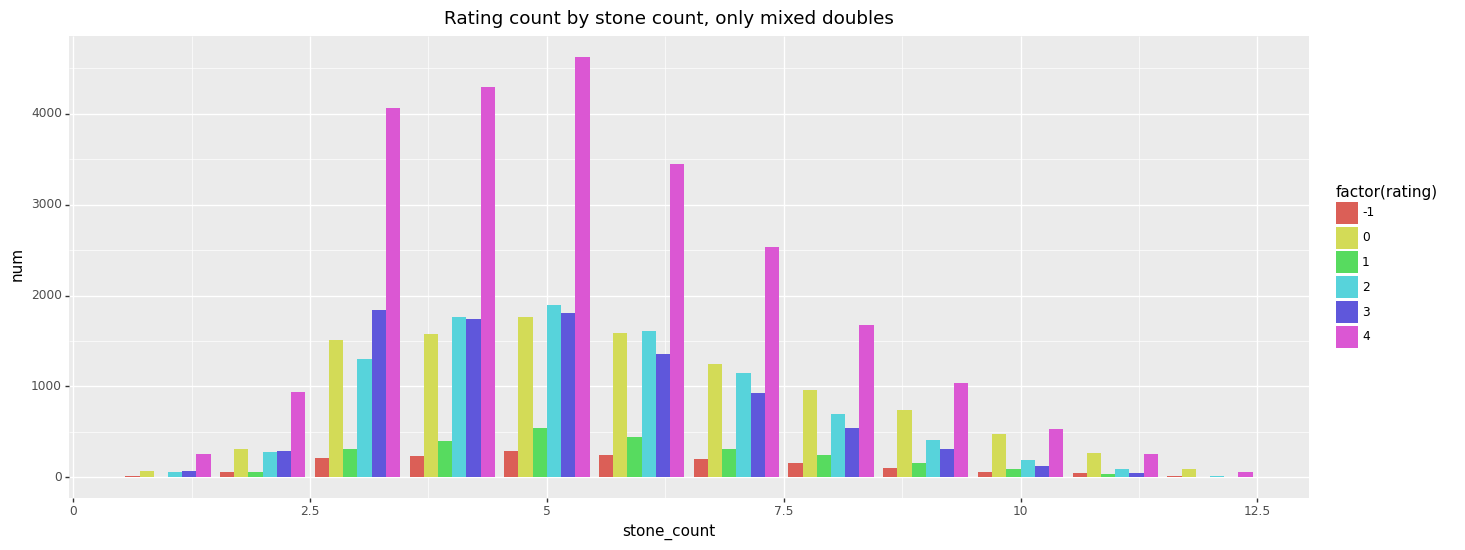

<ggplot: (692545708)>

In [23]:
(gg.ggplot(pd.DataFrame(linking.query('match_type == "Mixed_Doubles"')[['stone_count', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='stone_count', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by stone count, only mixed doubles'))

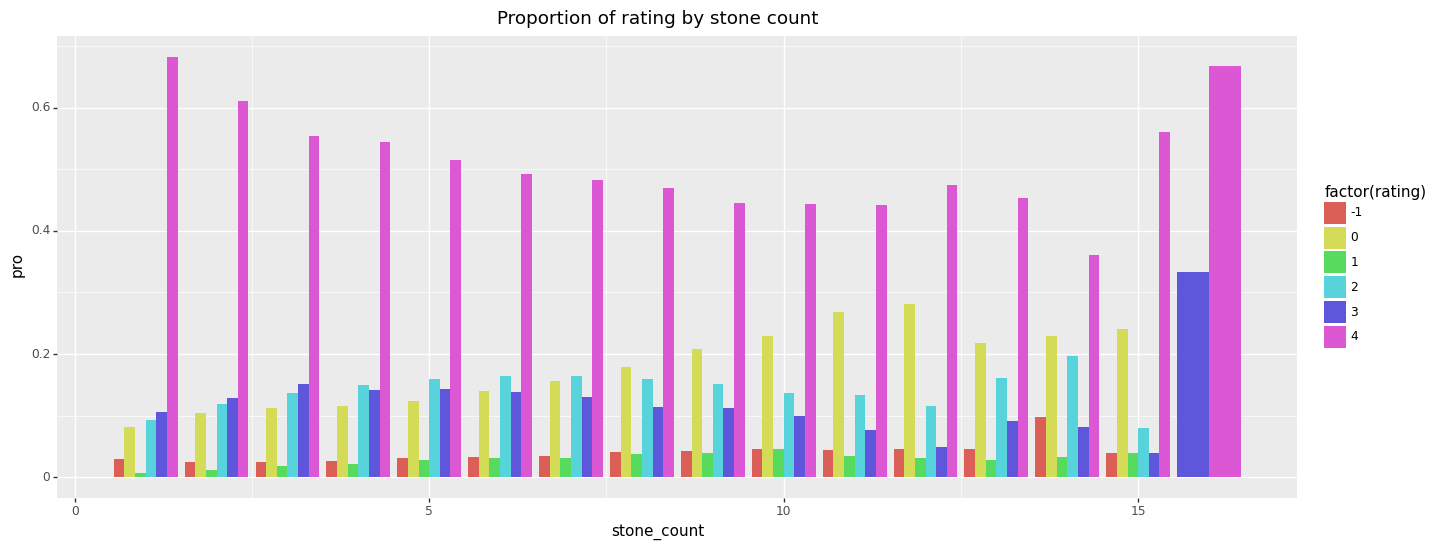

<ggplot: (689088386)>

In [24]:
df = pd.DataFrame(linking[['stone_count', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'})
df['pro'] = df.apply(lambda x: x['num'] / df.loc[df['stone_count'] == x['stone_count'], 'num'].sum(), axis=1)
(gg.ggplot(df, gg.aes(x='stone_count', y='pro', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Proportion of rating by stone count'))

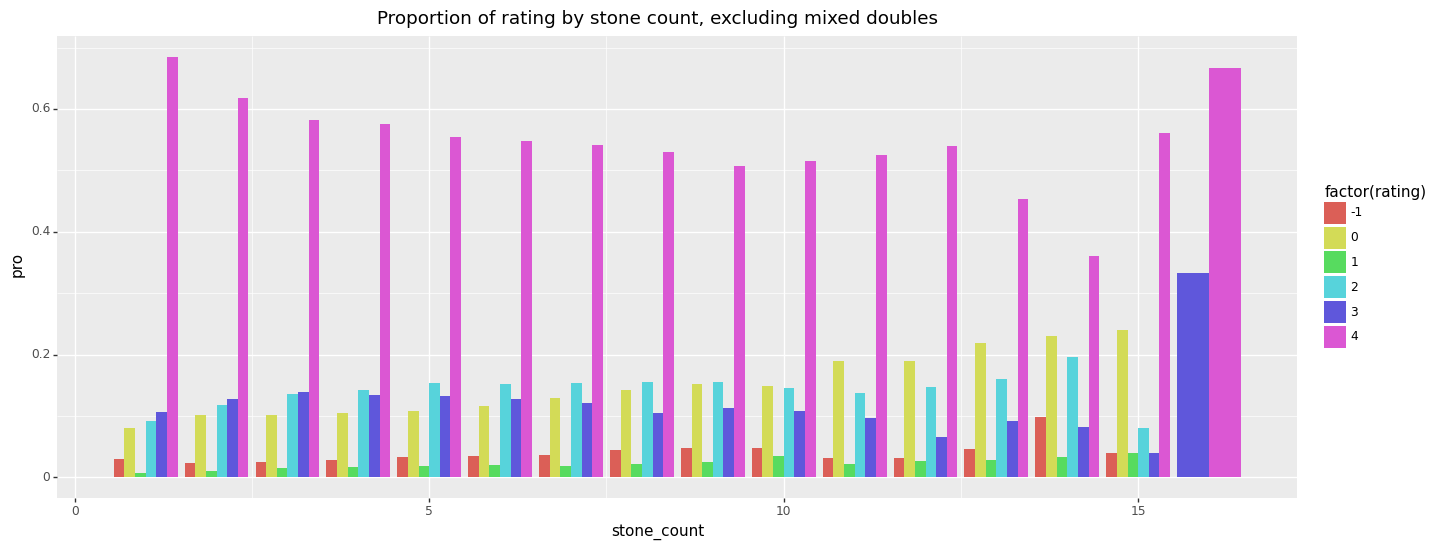

<ggplot: (689868222)>

In [25]:
df = pd.DataFrame(linking.query('match_type != "Mixed_Doubles"')[['stone_count', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'})
df['pro'] = df.apply(lambda x: x['num'] / df.loc[df['stone_count'] == x['stone_count'], 'num'].sum(), axis=1)
(gg.ggplot(df, gg.aes(x='stone_count', y='pro', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Proportion of rating by stone count, excluding mixed doubles'))

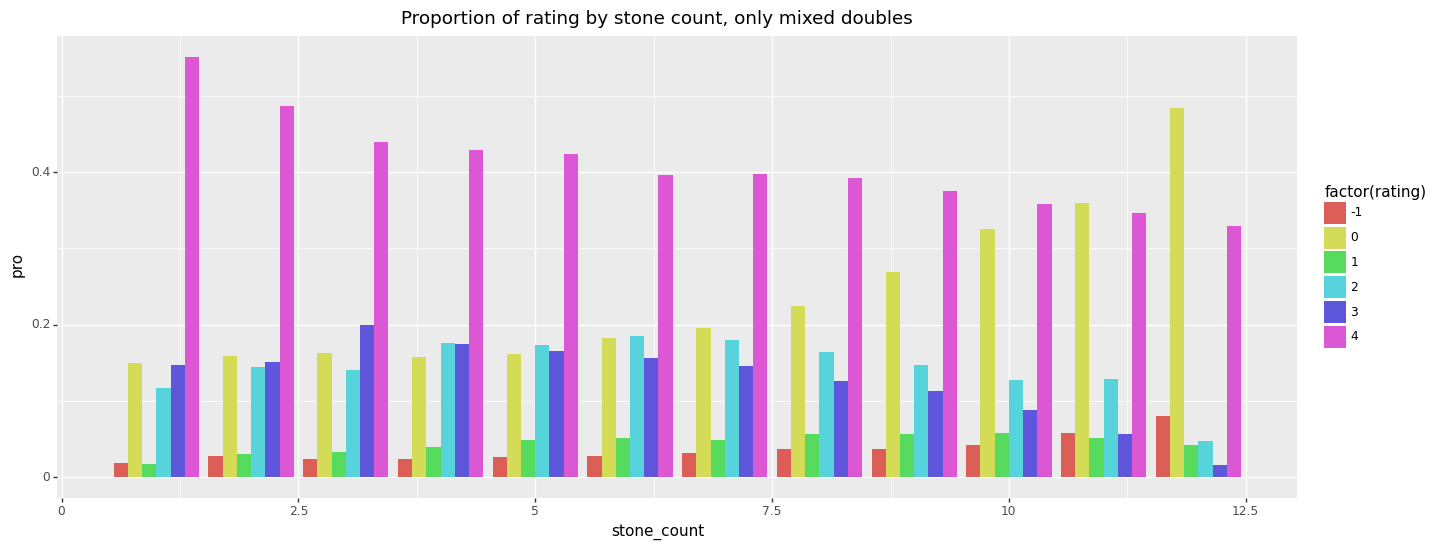

<ggplot: (699166338)>

In [26]:
df = pd.DataFrame(linking.query('match_type == "Mixed_Doubles"')[['stone_count', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'})
df['pro'] = df.apply(lambda x: x['num'] / df.loc[df['stone_count'] == x['stone_count'], 'num'].sum(), axis=1)
(gg.ggplot(df, gg.aes(x='stone_count', y='pro', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Proportion of rating by stone count, only mixed doubles'))

#### Summary

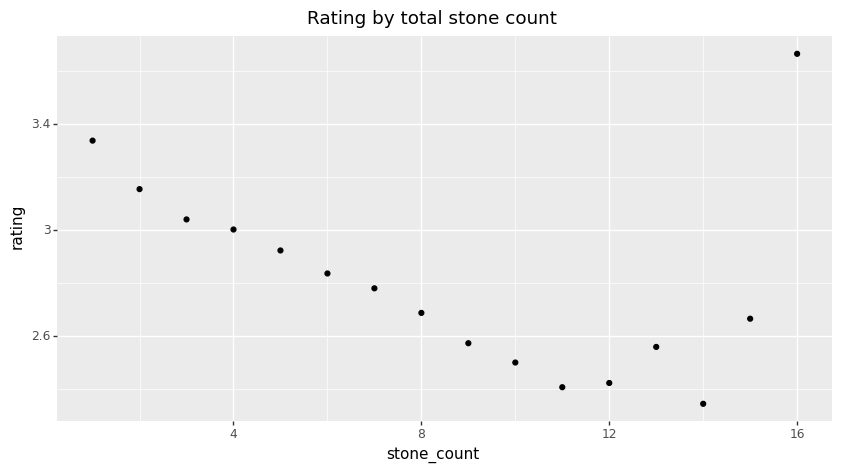

<ggplot: (698165357)>

In [27]:
(gg.ggplot(linking.query('rating != -1').groupby(['stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating')) 
    + gg.geom_point() 
    + pe.labels(title='Rating by total stone count')
    + gg.theme(figure_size=(10, 5))
    )

I suspect that the decline in rating here

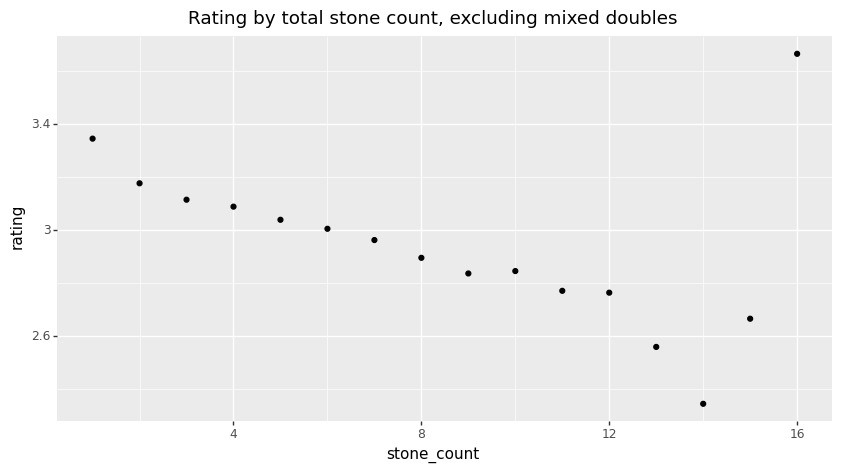

<ggplot: (696805581)>

In [28]:
(gg.ggplot(linking.query('(rating != -1)  & (match_type != "Mixed_Doubles")').groupby(['stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating')) 
    + gg.geom_point() 
    + pe.labels(title='Rating by total stone count, excluding mixed doubles')
    + gg.theme(figure_size=(10, 5))
    )

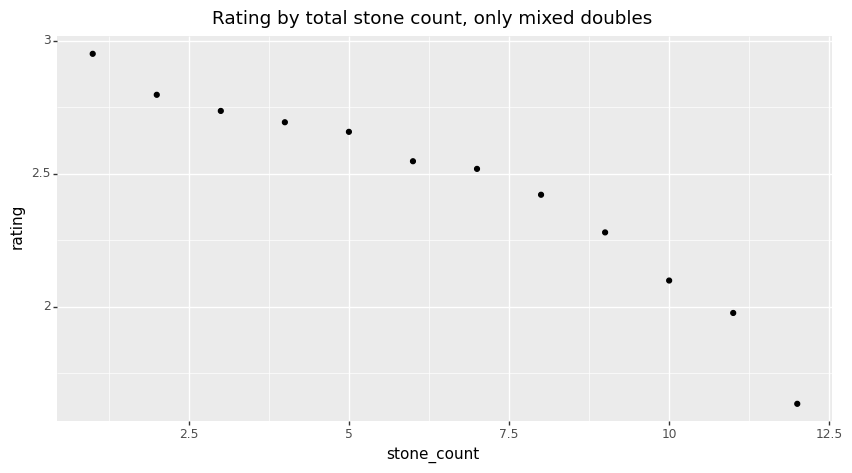

<ggplot: (698587251)>

In [29]:
(gg.ggplot(linking.query('(rating != -1)  & (match_type == "Mixed_Doubles")').groupby(['stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating')) 
    + gg.geom_point() 
    + pe.labels(title='Rating by total stone count, only mixed doubles')
    + gg.theme(figure_size=(10, 5))
    )

In [30]:
linking.query('rating != -1').groupby(['sex']).agg({'rating': 'mean'}).reset_index()

sex    rating
0   f  3.052543
1   m  3.195694
2   u  2.458963

In [31]:
linking.query('rating != -1').groupby(['match_type', 'sex']).agg({'rating': 'mean'}).reset_index()

match_type sex    rating
0     Mens_Teams   f  3.247126
1     Mens_Teams   m  3.238464
2  Mixed_Doubles   f  2.742204
3  Mixed_Doubles   m  2.859135
4  Mixed_Doubles   u  2.477466
5    Mixed_Teams   f  2.780105
6    Mixed_Teams   m  2.235294
7    Mixed_Teams   u  2.407580
8   Womens_Teams   f  3.081059
9   Womens_Teams   m  3.085034

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


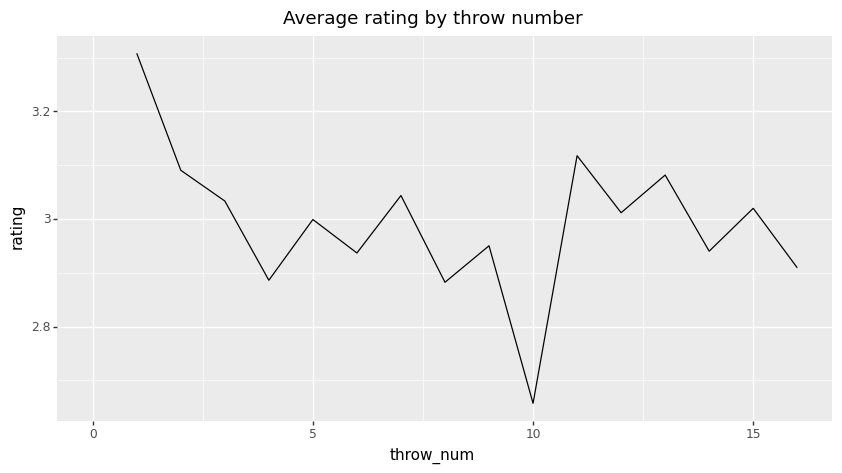

<ggplot: (694215066)>

In [32]:
(gg.ggplot(linking.query('rating != -1').groupby(['throw_num']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='throw_num', y='rating')) 
    + gg.geom_line() 
    + pe.labels(title='Average rating by throw number')
    + gg.theme(figure_size=(10, 5))
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


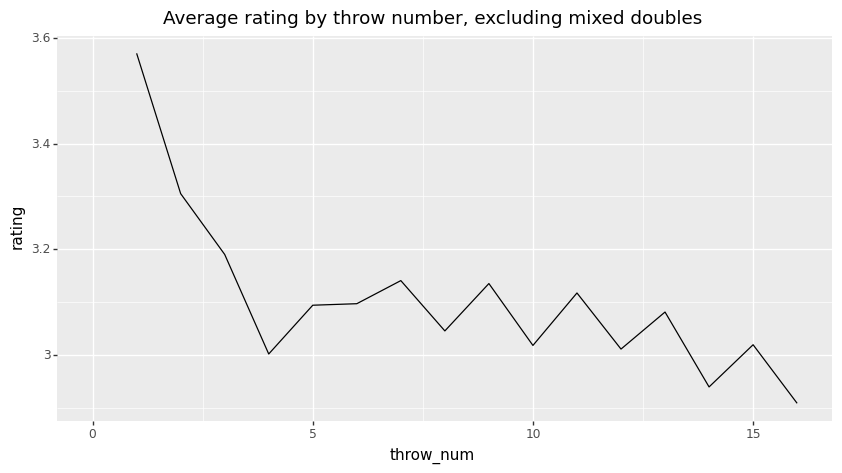

<ggplot: (700955109)>

In [33]:
(gg.ggplot(linking.query('(rating != -1) & (match_type != "Mixed_Doubles")').groupby(['throw_num']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='throw_num', y='rating')) 
    + gg.geom_line() 
    + pe.labels(title='Average rating by throw number, excluding mixed doubles')
    + gg.theme(figure_size=(10, 5))
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


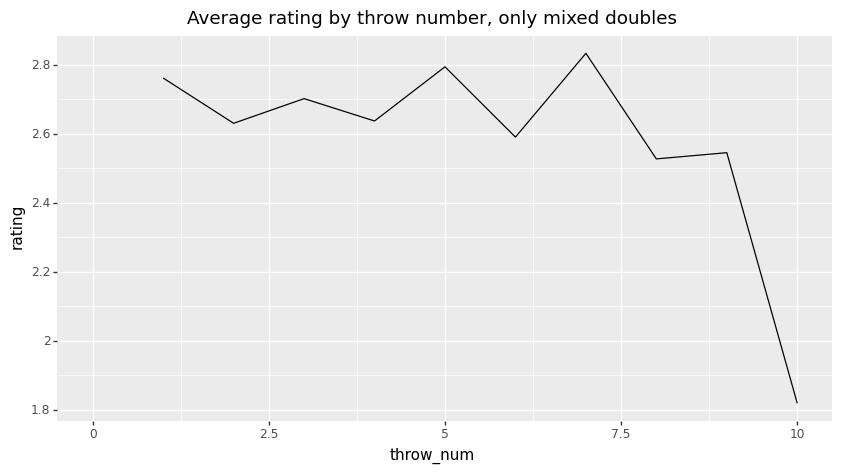

<ggplot: (700621096)>

In [34]:
(gg.ggplot(linking.query('(rating != -1) & (match_type == "Mixed_Doubles")').groupby(['throw_num']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='throw_num', y='rating')) 
    + gg.geom_line() 
    + pe.labels(title='Average rating by throw number, only mixed doubles')
    + gg.theme(figure_size=(10, 5))
    )

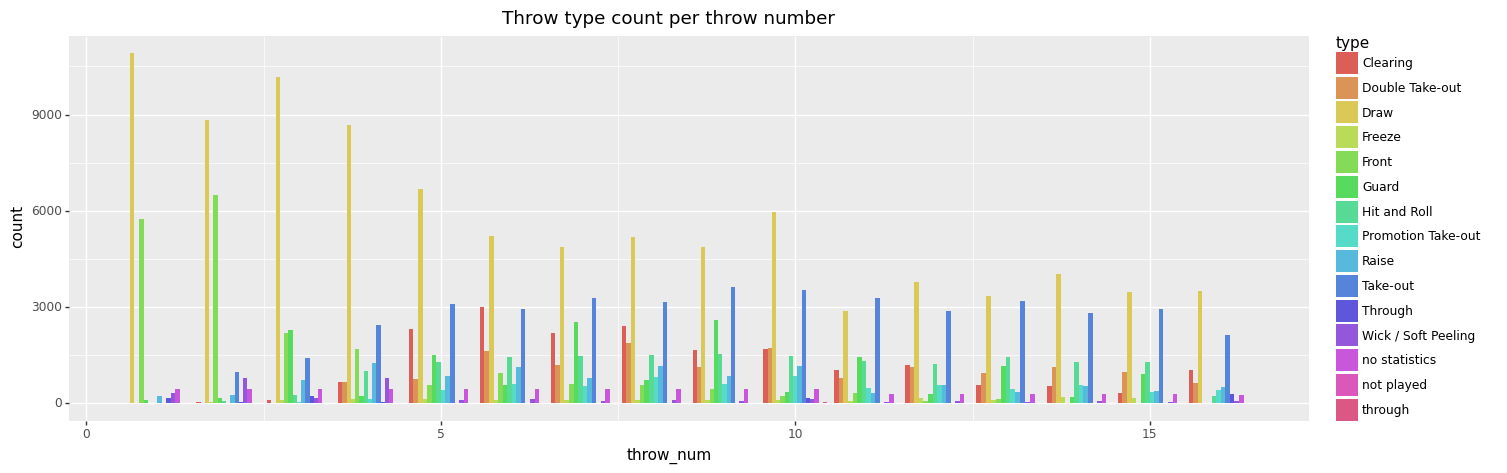

<ggplot: (702623236)>

In [35]:
# Throw count for the given throw count or number of stones
(gg.ggplot(linking.dropna(), gg.aes(x='throw_num', fill='type')) 
     + gg.geom_bar(position='dodge') 
     + gg.theme(figure_size=(16, 5)) 
     + pe.labels(title='Throw type count per throw number'))

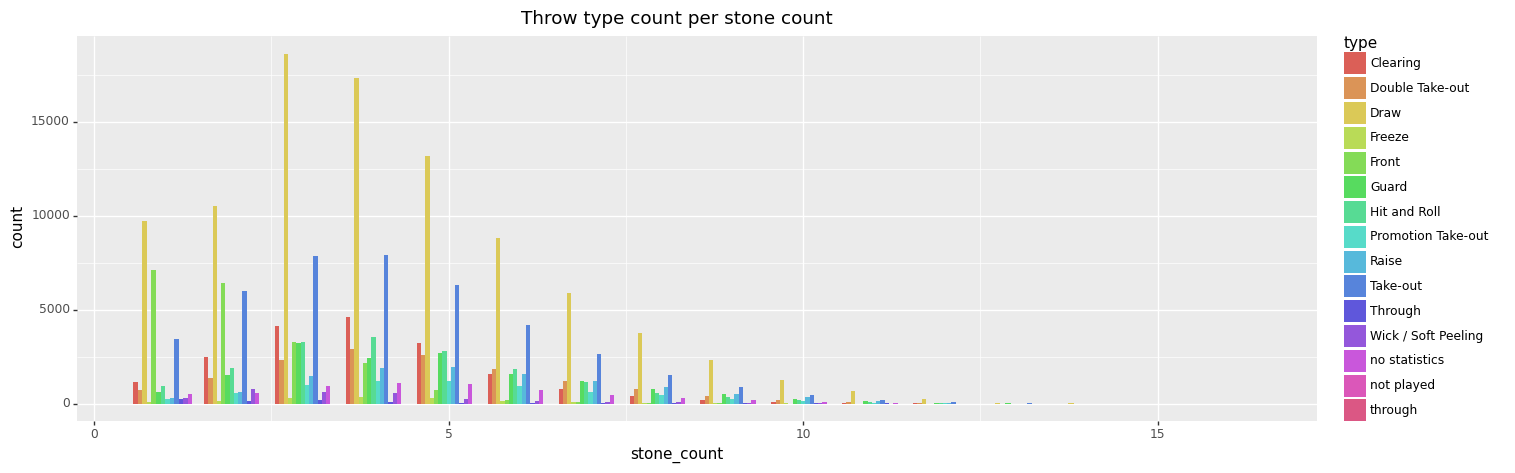

<ggplot: (702616510)>

In [36]:
(gg.ggplot(linking.dropna(), gg.aes(x='stone_count', fill='type')) 
    + gg.geom_bar(position='dodge') 
    + gg.theme(figure_size=(16, 5)) 
    + pe.labels(title='Throw type count per stone count'))

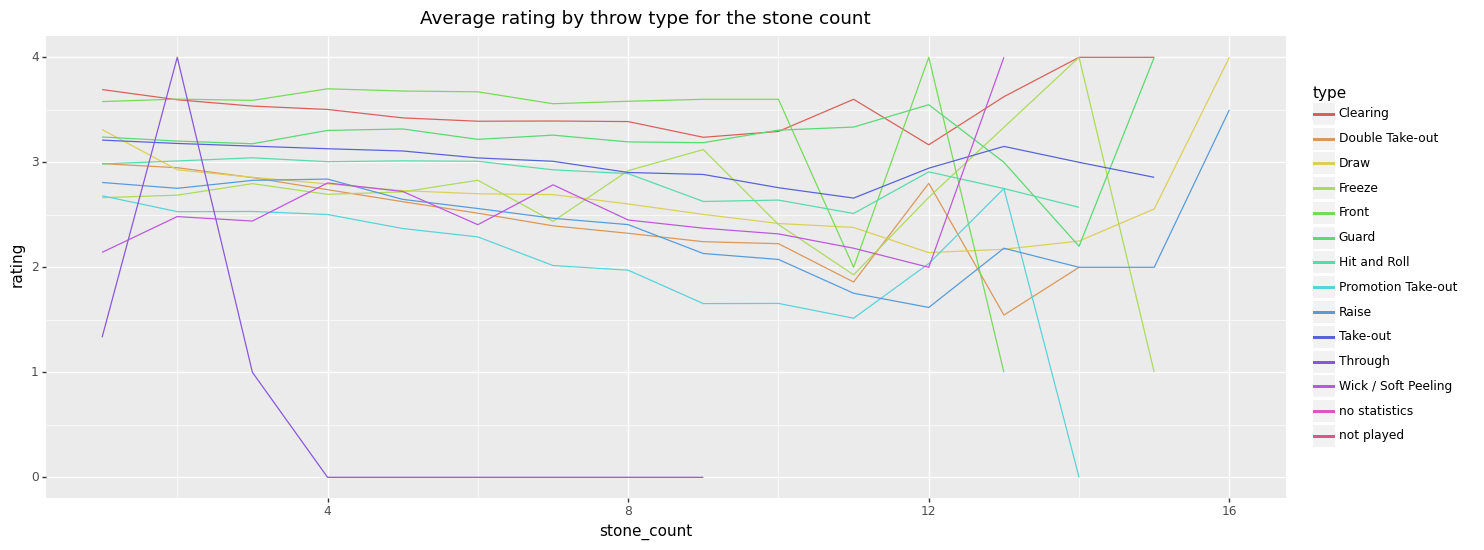

<ggplot: (702130119)>

In [37]:
(gg.ggplot(linking.query('rating != -1').groupby(['type', 'stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating', colour='type')) 
    + gg.geom_line() 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Average rating by throw type for the stone count'))

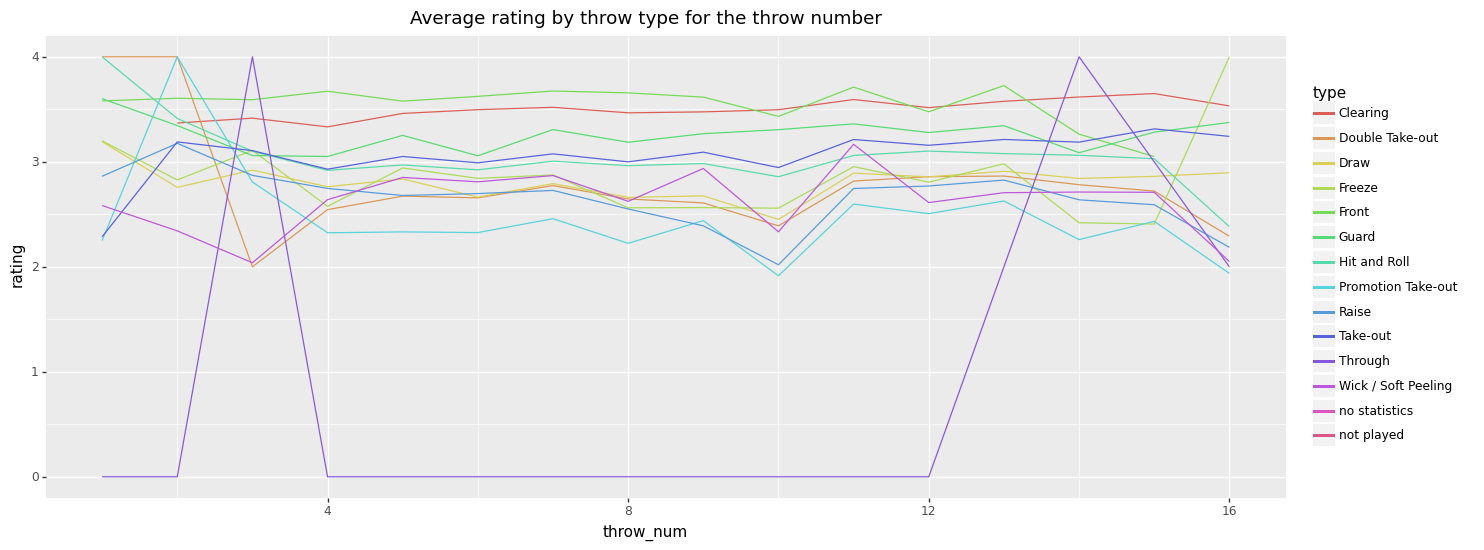

<ggplot: (701833433)>

In [38]:
(gg.ggplot(linking.query('rating != -1').groupby(['type', 'throw_num']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='throw_num', y='rating', colour='type')) 
    + gg.geom_line() 
    + gg.theme(figure_size=(16, 6))
    + pe.labels(title='Average rating by throw type for the throw number'))

## Player Accuracy

### Query

In [39]:
player_cmd = """
SELECT p.name, p.team, p.sex, t.throw_num, t.type, t.rating, e.hammer_colour, DATE(m.start_time), m.type, e1.abbrev
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
JOIN End e
  ON t.end_id = e.end_id
JOIN Match m
  ON e.match_id = m.match_id
JOIN Event e1
  ON m.event_id = e1.event_id
"""
db.execute_query(player_cmd)
players = pd.DataFrame(db.cursor.fetchall(), columns=['name', 'team', 'sex', 'throw_num', 'throw_type', 'rating', 'hammer_colour', 'date', 'match_type', 'event'])
players['country'] = players.apply(lambda x: x['team'][:3], axis=1)
print(players.shape)
players.head()

(255097, 11)


name team sex  throw_num throw_type  rating hammer_colour  \
0  FREDERICKS ARMSTR.  AUS   f          1       Draw     0.0           red   
1          THOMPSON H  NZL   f          2      Front     2.0           red   
2  FREDERICKS ARMSTR.  AUS   f          3       Draw     3.0           red   
3          THOMPSON H  NZL   f          4       Draw     4.0           red   
4            POWELL A  AUS   f          5   Take-out     2.0           red   

         date    match_type          event country  
0  2017-11-04  Womens_Teams  CUR_PACC2017B     AUS  
1  2017-11-04  Womens_Teams  CUR_PACC2017B     NZL  
2  2017-11-04  Womens_Teams  CUR_PACC2017B     AUS  
3  2017-11-04  Womens_Teams  CUR_PACC2017B     NZL  
4  2017-11-04  Womens_Teams  CUR_PACC2017B     AUS

### Top rated players with over 50 throws

In [40]:
player_ratings = players.groupby(['name', 'team', 'sex']).agg({'rating':[('mean', 'mean'), ('count', 'count')]})
player_ratings.columns = ['_'.join(col) for col in player_ratings.columns.values]
player_ratings = player_ratings.dropna().reset_index()
player_ratings.query('rating_count > 50').sort_values('rating_mean', ascending=False).reset_index().query('name == "MARKS A"').head(30)

index     name team sex  rating_mean  rating_count
275    508  MARKS A  CAN   f     3.081633            98

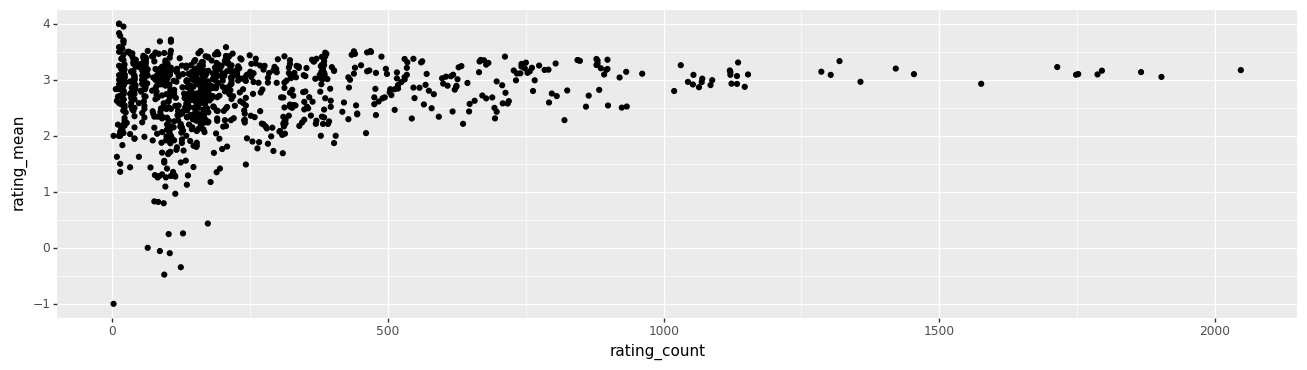

<ggplot: (706324095)>

In [41]:
(gg.ggplot(player_ratings, gg.aes(x='rating_count', y='rating_mean')) 
    + gg.geom_point() 
    + gg.theme(figure_size=(16, 4)))

### Most Experienced Players

In [42]:
player_ratings.sort_values('rating_count', ascending=False).head(15)

name team sex  rating_mean  rating_count
175      ERIKSSON O  SWE   m     3.172936          2047
275    HASSELBORG A  SWE   f     3.052023          1903
588   NEDREGOTTEN M  NOR   m     3.137728          1866
808      SUNDGREN C  SWE   m     3.163231          1795
499       MABERGS S  SWE   f     3.096251          1787
167          EDIN N  SWE   m     3.102740          1752
579       McMANUS S  SWE   f     3.090389          1748
410  KNOCHENHAUER A  SWE   f     3.227538          1714
395           KIM S  KOR   f     2.928934          1576
555       MOSANER A  ITA   m     3.101100          1454
269      HAMILTON M  USA   m     3.200563          1421
951       ZAPPONE V  ITA   f     2.964628          1357
922        WRANAA R  SWE   m     3.333586          1319
690      RETORNAZ J  ITA   m     3.088258          1303
463           LEE K  KOR   m     3.144635          1286

### Top rated countries

In [43]:
country_ratings = players.groupby(['country']).agg({'rating':[('mean', 'mean'), ('count', 'count')]})
country_ratings.columns = ['_'.join(col) for col in country_ratings.columns.values]
country_ratings = country_ratings.dropna().reset_index()
country_ratings.sort_values('rating_mean', ascending=False).head(15)

country  rating_mean  rating_count
6      CAN     3.058203         17817
49     SWE     3.053255         19153
44     SCO     3.025528         16805
24     ITA     3.023248         11915
9      CZE     3.010452          6506
10     DEN     2.999789          9494
16     GBR     2.968237          2739
43     RUS     2.966911         15292
47     SUI     2.966909         18464
39     OAR     2.939544          1009
53     USA     2.918622         15729
34     NED     2.917202          4517
25     JPN     2.916419         11115
36     NOR     2.912106         13118
13     EST     2.911322          1263

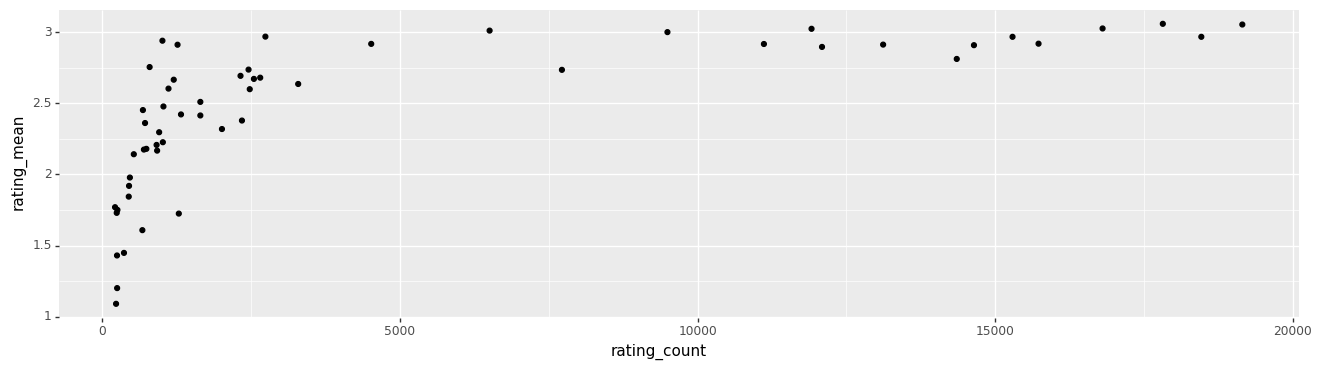

<ggplot: (706324059)>

In [44]:
(gg.ggplot(country_ratings, gg.aes(x='rating_count', y='rating_mean')) 
    + gg.geom_point() 
    + gg.theme(figure_size=(16, 4)))

## Eriksson, O Analysis - 237
- Eriksson - 237
- Marks - 892
- Sturmay - 894

In [45]:
erik_cmd = """
SELECT p.name, p.team, p.sex, t.throw_num, t.type, t.rating, e.hammer_colour, DATE(m.start_time), m.type, e1.abbrev, DATE(e1.start_date)
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
JOIN End e
  ON t.end_id = e.end_id
JOIN Match m
  ON e.match_id = m.match_id
JOIN Event e1
  ON m.event_id = e1.event_id
WHERE p.player_id = 237
"""
db.execute_query(erik_cmd)
eriksson = pd.DataFrame(db.cursor.fetchall(), columns=['name', 'team', 'sex', 'throw_num', 'throw_type', 'rating', 'hammer_colour', 'date', 'match_type', 'event', 'event_date'])
eriksson['date'] = pd.to_datetime(eriksson.date)
eriksson['event_date'] = pd.to_datetime(eriksson.event_date)
print(eriksson.shape)
eriksson.head()

(2047, 11)


name team sex  throw_num throw_type  rating hammer_colour       date  \
0  ERIKSSON O  SWE   m          4       Draw       3           red 2019-04-25   
1  ERIKSSON O  SWE   m          6       Draw       4           red 2019-04-25   
2  ERIKSSON O  SWE   m          8      Guard       4           red 2019-04-25   
3  ERIKSSON O  SWE   m          3      Raise       4           red 2019-04-25   
4  ERIKSSON O  SWE   m          5       Draw       4           red 2019-04-25   

      match_type           event event_date  
0  Mixed_Doubles  CUR_WMDCC2019P 2019-04-20  
1  Mixed_Doubles  CUR_WMDCC2019P 2019-04-20  
2  Mixed_Doubles  CUR_WMDCC2019P 2019-04-20  
3  Mixed_Doubles  CUR_WMDCC2019P 2019-04-20  
4  Mixed_Doubles  CUR_WMDCC2019P 2019-04-20

In [46]:
# Add dates
eriksson['year'] = pd.to_datetime(eriksson['date'].apply(lambda x: x.year))
eriksson['month'] = pd.to_datetime(eriksson['date'].apply(lambda x: datetime.date(year=x.year, month=x.month, day=1)))
for col in ['team', 'sex', 'throw_type', 'hammer_colour', 'match_type', 'event']:
    eriksson[col] = pd.Categorical(eriksson[col])
eriksson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           2047 non-null   object        
 1   team           2047 non-null   category      
 2   sex            2047 non-null   category      
 3   throw_num      2047 non-null   int64         
 4   throw_type     2047 non-null   category      
 5   rating         2047 non-null   int64         
 6   hammer_colour  2047 non-null   category      
 7   date           2047 non-null   datetime64[ns]
 8   match_type     2047 non-null   category      
 9   event          2047 non-null   category      
 10  event_date     2047 non-null   datetime64[ns]
 11  year           2047 non-null   datetime64[ns]
 12  month          2047 non-null   datetime64[ns]
dtypes: category(6), datetime64[ns](4), int64(2), object(1)
memory usage: 125.6+ KB


### Rating by Tournament

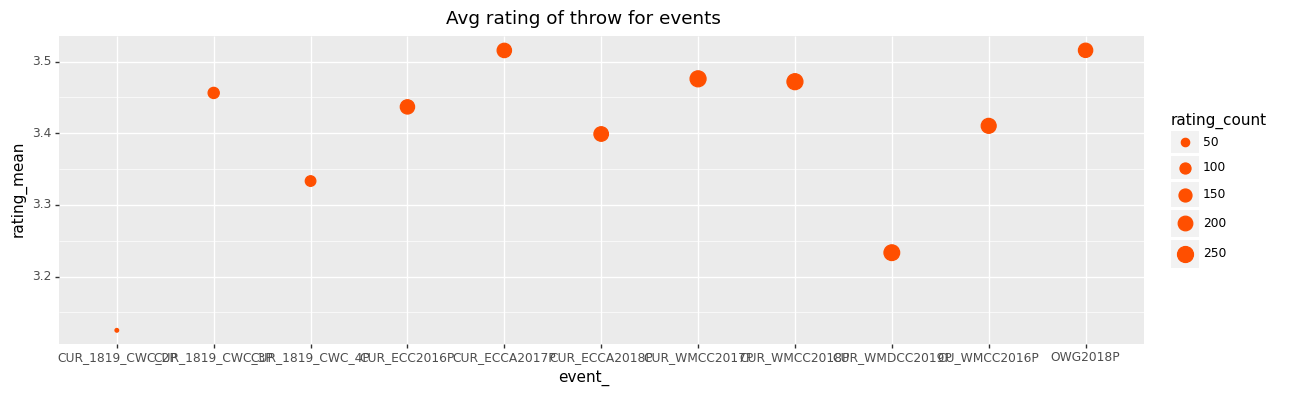

<ggplot: (706298043)>

In [47]:
eriksson_event = eriksson.groupby(['event', 'event_date']).agg({'rating':[('mean', 'mean'), ('count', 'count')]}).reset_index()
eriksson_event.columns = ['_'.join(col) for col in eriksson_event.columns.values]
(gg.ggplot(eriksson_event.query('rating_mean > 0').sort_values('event_date_'), gg.aes(x='event_', y='rating_mean', size='rating_count')) 
    + gg.geom_point(colour='#ff4f00') 
    # + gg.scale_x_datetime()
    + pe.labels('Avg rating of throw for events')
    + gg.theme(figure_size=(14, 4))
    )

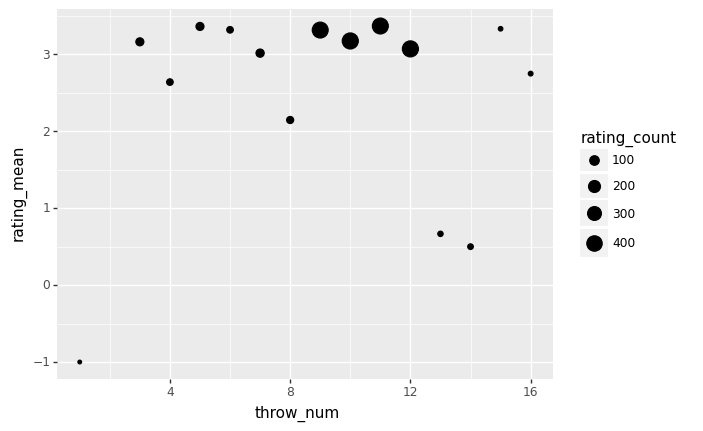

<ggplot: (696231515)>

In [48]:
eriksson_throw = eriksson.groupby('throw_num').agg({'rating': ['mean', 'count']})
eriksson_throw.columns = ['_'.join(col) for col in eriksson_throw.columns.values]
eriksson_throw.reset_index()
gg.ggplot(eriksson_throw.reset_index(), gg.aes(x='throw_num', y='rating_mean', size='rating_count')) + gg.geom_point()

             throw_type  rating_mean  rating_count
0              Clearing     3.833811           349
1       Double Take-out     3.120603           199
2                  Draw     3.364865           444
3                Freeze     3.000000             7
4                 Front     3.470588            17
5                 Guard     3.558559           111
6          Hit and Roll     3.301075           186
7    Promotion Take-out     2.841379           145
8                 Raise     3.207317            82
9              Take-out     3.614173           381
10              Through    -1.000000             1
11  Wick / Soft Peeling     3.500000             6
12        no statistics    -1.000000           117
13              through    -1.000000             2


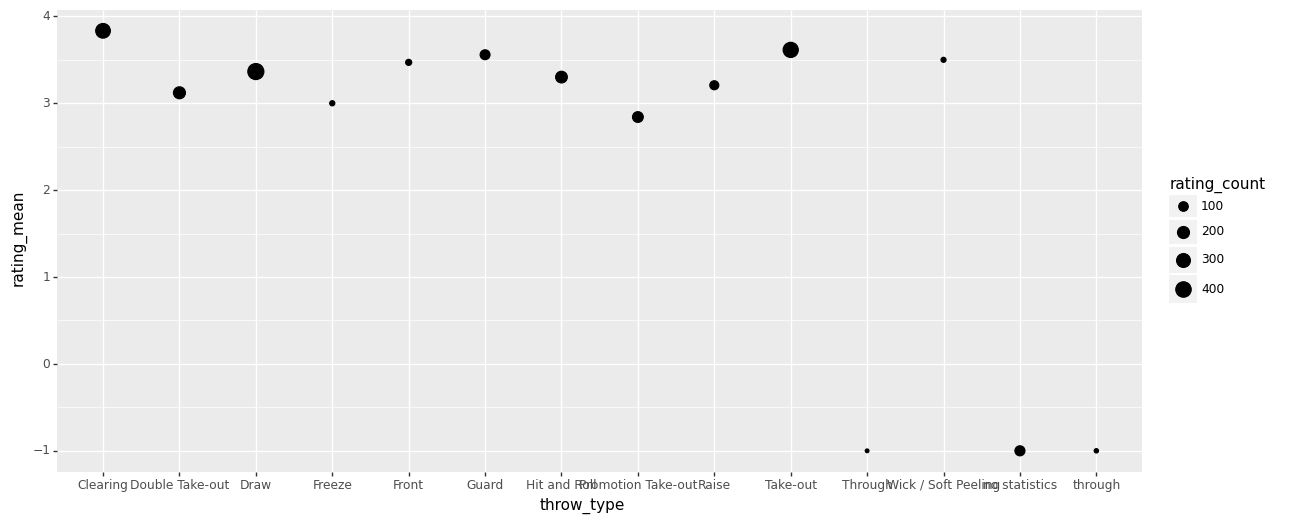

<ggplot: (700520358)>

In [49]:
eriksson_type = eriksson.groupby(['throw_type']).agg({'rating':[('mean', 'mean'), ('count', 'count')]})
eriksson_type.columns = ['_'.join(col) for col in eriksson_type.columns.values]
print(eriksson_type.reset_index())
(gg.ggplot(eriksson_type.reset_index(), gg.aes(x='throw_type', y='rating_mean', size='rating_count')) 
    + gg.geom_point() 
    + gg.theme(figure_size=(14, 6))
    )

In [50]:
eriksson_type.reset_index().melt(id_vars='throw_type', value_vars=['rating_mean'])

throw_type     variable     value
0              Clearing  rating_mean  3.833811
1       Double Take-out  rating_mean  3.120603
2                  Draw  rating_mean  3.364865
3                Freeze  rating_mean  3.000000
4                 Front  rating_mean  3.470588
5                 Guard  rating_mean  3.558559
6          Hit and Roll  rating_mean  3.301075
7    Promotion Take-out  rating_mean  2.841379
8                 Raise  rating_mean  3.207317
9              Take-out  rating_mean  3.614173
10              Through  rating_mean -1.000000
11  Wick / Soft Peeling  rating_mean  3.500000
12        no statistics  rating_mean -1.000000
13              through  rating_mean -1.000000

In [51]:
# Count of rating for throw count
# Average of the ratings
# eriksson_type_count = eriksson.groupby(['throw_type', 'rating']).agg({'name':'count'}).reset_index().pivot(index='throw_type', columns=['rating'])
eriksson_type_count = eriksson.groupby(['throw_type', 'rating']).agg({'name':'count'}).reset_index()
eriksson_type_count
pd.concat([eriksson_type_count, ])
# eriksson_type.join(eriksson_type_count)


throw_type  rating  name
0              Clearing      -1     0
1              Clearing       0     5
2              Clearing       1     3
3              Clearing       2    14
4              Clearing       3     1
5              Clearing       4   326
6       Double Take-out      -1     0
7       Double Take-out       0     7
8       Double Take-out       1     0
9       Double Take-out       2    68
10      Double Take-out       3    11
11      Double Take-out       4   113
12                 Draw      -1     1
13                 Draw       0    22
14                 Draw       1     4
15                 Draw       2    47
16                 Draw       3    83
17                 Draw       4   287
18               Freeze      -1     0
19               Freeze       0     0
20               Freeze       1     0
21               Freeze       2     2
22               Freeze       3     3
23               Freeze       4     2
24                Front      -1     0
25                Front       0     2
26                Front       1     0
27                Front       2     0
28                Front       3     1
29                Front       4    14
30                Guard      -1     1
31                Guard       0     0
32                Guard       1     2
33                Guard       2    12
34                Guard       3    14
35                Guard       4    82
36         Hit and Roll      -1     0
37         Hit and Roll       0     7
38         Hit and Roll       1     0
39         Hit and Roll       2    11
40         Hit and Roll       3    80
41         Hit and Roll       4    88
42   Promotion Take-out      -1     0
43   Promotion Take-out       0    22
44   Promotion Take-out       1     3
45   Promotion Take-out       2    31
46   Promotion Take-out       3     9
47   Promotion Take-out       4    80
48                Raise      -1     0
49                Raise       0     9
50                Raise       1     2
51                Raise       2     3
52                Raise       3    17
53                Raise       4    51
54             Take-out      -1     0
55             Take-out       0    16
56             Take-out       1     2
57             Take-out       2    34
58             Take-out       3     9
59             Take-out       4   320
60              Through      -1     1
61              Through       0     0
62              Through       1     0
63              Through       2     0
64              Through       3     0
65              Through       4     0
66  Wick / Soft Peeling      -1     0
67  Wick / Soft Peeling       0     0
68  Wick / Soft Peeling       1     0
69  Wick / Soft Peeling       2     1
70  Wick / Soft Peeling       3     1
71  Wick / Soft Peeling       4     4
72        no statistics      -1   117
73        no statistics       0     0
74        no statistics       1     0
75        no statistics       2     0
76        no statistics       3     0
77        no statistics       4     0
78              through      -1     2
79              through       0     0
80              through       1     0
81              through       2     0
82              through       3     0
83              through       4     0